In [1]:
import operator
from pprint import pprint
import itertools
import numpy as np

from SolrClient import SolrClient

import gensim
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
from gensim import matutils

import pyLDAvis.gensim

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline

D:\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)
pyLDAvis.enable_notebook()

In [3]:
solr = SolrClient('http://192.168.200.112:8983')

In [4]:
query_def = {
            'q': '-ctr_id:id_document_spell',
            'indent': 'true',
            'fl': 'ctr_id,ctr_content_nlp',
            'wt': 'json',
            'rows': '2147483647'
            }

In [5]:
res = solr.query('default',query_def)

2017-07-31 15:22:02,426 : DEBUG : Sending Request to http://192.168.200.112:8983/default/select with q=-ctr_id:id_document_spell, indent=false, fl=ctr_id,ctr_content_nlp, wt=json, rows=2147483647
2017-07-31 15:22:02,451 : DEBUG : Starting new HTTP connection (1): 192.168.200.112
2017-07-31 15:22:02,633 : DEBUG : http://192.168.200.112:8983 "POST /default/select?q=-ctr_id%3Aid_document_spell&indent=false&fl=ctr_id%2Cctr_content_nlp&wt=json&rows=2147483647 HTTP/1.1" 200 None
2017-07-31 15:22:12,170 : DEBUG : Request Completed in 9.74 Seconds


In [6]:
res.get_results_count()

41283

In [7]:
def process_texts(docs, text_fields, language='portuguese'):
    """
    Function to process texts. Following are the steps we take:

    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).

    Parameters:
    ----------
    texts: Tokenized texts.

    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    texts = []
    for doc in docs:
        text = None
        for text_field in text_fields:
            if text_field in doc:
                text = gensim.utils.simple_preprocess(doc[text_field], deacc=False, min_len=3)
                texts.append(text)
    stops = set(stopwords.words(language))
    texts = [[word for word in text if word not in stops] for text in texts]
    
    phrases = gensim.models.Phrases(texts)
    bigram = gensim.models.phrases.Phraser(phrases)
    
    for idx in range(len(texts)):
        for token in bigram[texts[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                texts[idx].append(token)
    
    return texts

In [8]:
%%time
train_texts = process_texts(res.docs, ['ctr_content_nlp'])

2017-07-31 15:22:29,949 : INFO : collecting all words and their counts
2017-07-31 15:22:29,949 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2017-07-31 15:22:30,841 : INFO : PROGRESS: at sentence #10000, processed 592598 words and 300699 word types
2017-07-31 15:22:31,660 : INFO : PROGRESS: at sentence #20000, processed 1139017 words and 519305 word types
2017-07-31 15:22:32,634 : INFO : PROGRESS: at sentence #30000, processed 1725179 words and 721056 word types
2017-07-31 15:22:33,484 : INFO : PROGRESS: at sentence #40000, processed 2264246 words and 878502 word types
2017-07-31 15:22:33,575 : INFO : collected 896189 word types from a corpus of 2322953 words (unigram + bigrams) and 41283 sentences
2017-07-31 15:22:33,575 : INFO : using 896189 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2017-07-31 15:22:33,575 : INFO : source_vocab length 896189
2017-07-31 15:22:42,764 : INFO : Phraser built with 11343 11343 phrasegr

Wall time: 23.4 s


In [9]:
len(train_texts)

41283

In [10]:
str(train_texts[0])

"['crédito', 'financiar', 'investir', 'torre', 'andar', 'conj', 'crédito', 'liquidar', 'bilhão', 'bilhão', 'indicar', 'financeira', 'melhores', 'cumprimento', 'disposição', 'apreciar', 'empresa', 'revista', 'época', 'edição', 'demonstração', 'crédito', 'financiamento', 'despesa', 'provisão', 'crédito', 'liquidar', 'premiações', 'resultado', 'política', 'gestão', 'vestimento', 'financeira', 'exercício', 'rência', 'melhora', 'qualidade', 'ativo', 'financeira', 'pessoa', 'resultados', 'empresa', 'manutenção', 'equipe', 'nota', 'parecer', 'auditor', 'redução', 'despesa', 'realizar', 'operação', 'ces', 'colaborar', 'estratégia', 'diversificar', 'produto', 'financeira', 'crédito', 'atraso', 'mercado', 'operação', 'impacto', 'adicionalmeis', 'contagem', 'risco', 'tomador', 'redução', 'deterioração', 'classificação', 'dobro', 'intervalo', 'atraso', 'nível', 'renda', 'categoria', 'item', 'objeto', 'ajuste', 'valor', 'ganho', 'remunerar', 'vantagem', 'negociar', 'custo', 'período', 'mercado', 'c

In [11]:
dictionary = Dictionary(train_texts)

2017-07-31 15:23:18,141 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-07-31 15:23:18,996 : INFO : adding document #10000 to Dictionary(34839 unique tokens: ['crédito', 'financiar', 'investir', 'torre', 'andar']...)
2017-07-31 15:23:19,800 : INFO : adding document #20000 to Dictionary(48251 unique tokens: ['crédito', 'financiar', 'investir', 'torre', 'andar']...)
2017-07-31 15:23:20,717 : INFO : adding document #30000 to Dictionary(58567 unique tokens: ['crédito', 'financiar', 'investir', 'torre', 'andar']...)
2017-07-31 15:23:21,542 : INFO : adding document #40000 to Dictionary(65930 unique tokens: ['crédito', 'financiar', 'investir', 'torre', 'andar']...)
2017-07-31 15:23:21,641 : INFO : built Dictionary(66735 unique tokens: ['crédito', 'financiar', 'investir', 'torre', 'andar']...) from 41283 documents (total 2668056 corpus positions)


In [12]:
print('Number of unique tokens: %d' % len(dictionary))

Number of unique tokens: 66735


In [13]:
dictionary.save('mp_dictionary_full.dict')

2017-07-31 15:23:29,229 : INFO : saving Dictionary object under mp_dictionary_full.dict, separately None
2017-07-31 15:23:29,259 : INFO : saved mp_dictionary_full.dict


In [14]:
dictionary_filtered = Dictionary(train_texts)
dictionary_filtered.save('mp_dictionary_filtered.dict')
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)
dictionary_filtered.filter_extremes(no_above=0.5)
print('Number of unique tokens: %d' % len(dictionary_filtered))

2017-07-31 15:23:34,766 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-07-31 15:23:35,622 : INFO : adding document #10000 to Dictionary(34839 unique tokens: ['crédito', 'financiar', 'investir', 'torre', 'andar']...)
2017-07-31 15:23:36,460 : INFO : adding document #20000 to Dictionary(48251 unique tokens: ['crédito', 'financiar', 'investir', 'torre', 'andar']...)
2017-07-31 15:23:37,378 : INFO : adding document #30000 to Dictionary(58567 unique tokens: ['crédito', 'financiar', 'investir', 'torre', 'andar']...)
2017-07-31 15:23:38,165 : INFO : adding document #40000 to Dictionary(65930 unique tokens: ['crédito', 'financiar', 'investir', 'torre', 'andar']...)
2017-07-31 15:23:38,262 : INFO : built Dictionary(66735 unique tokens: ['crédito', 'financiar', 'investir', 'torre', 'andar']...) from 41283 documents (total 2668056 corpus positions)
2017-07-31 15:23:38,262 : INFO : saving Dictionary object under mp_dictionary_filtered.dict, separately None
2017-07-31 15:23:38,

Number of unique tokens: 22630


In [15]:
corpus = [dictionary.doc2bow(text) for text in train_texts]
print('Number of documents on full: %d' % len(corpus))
corpus_filtered = [dictionary_filtered.doc2bow(text) for text in train_texts]
print('Number of documents on filtered: %d' % len(corpus_filtered))

Number of documents on full: 41283
Number of documents on filtered: 41283


In [16]:
%%time
ldamodel_filtered = LdaModel(corpus=corpus_filtered, num_topics=10, id2word=dictionary_filtered, chunksize=45000, passes=10, iterations=400, eval_every=1, alpha='auto', eta='auto')

2017-07-31 15:24:06,656 : INFO : using autotuned alpha, starting with [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
2017-07-31 15:24:06,662 : INFO : using serial LDA version on this node
2017-07-31 15:24:07,921 : INFO : running online (multi-pass) LDA training, 10 topics, 10 passes over the supplied corpus of 41283 documents, updating model once every 41283 documents, evaluating perplexity every 41283 documents, iterating 400x with a convergence threshold of 0.001000
2017-07-31 15:24:09,843 : DEBUG : bound: at document #0
2017-07-31 15:31:01,297 : INFO : -10.712 per-word bound, 1677.7 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-07-31 15:31:01,297 : INFO : PROGRESS: pass 0, at document #41283/41283
2017-07-31 15:31:01,297 : DEBUG : performing inference on a chunk of 41283 documen

2017-07-31 15:49:30,324 : INFO : topic #1 (0.065): 0.024*"item" + 0.023*"valor" + 0.018*"objeto" + 0.017*"empresa" + 0.016*"preço" + 0.014*"processo" + 0.013*"edital" + 0.012*"contrato" + 0.010*"licitar" + 0.009*"aquisição"
2017-07-31 15:49:30,328 : INFO : topic diff=0.426961, rho=0.447214
2017-07-31 15:49:30,859 : DEBUG : bound: at document #0
2017-07-31 15:52:02,635 : INFO : -7.306 per-word bound, 158.3 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-07-31 15:52:02,635 : INFO : PROGRESS: pass 4, at document #41283/41283
2017-07-31 15:52:02,635 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-31 15:52:52,116 : DEBUG : 41281/41283 documents converged within 400 iterations
2017-07-31 15:52:52,889 : INFO : optimized alpha [0.053773690934311939, 0.064964040863331435, 0.042774290822889173, 0.055653130687785698, 0.04806977022753766, 0.0524139962203743, 0.053922201294170073, 0.051241390903332955, 0.049711858126981631, 0.0417367518

2017-07-31 16:02:35,968 : DEBUG : bound: at document #0
2017-07-31 16:05:00,643 : INFO : -7.202 per-word bound, 147.2 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-07-31 16:05:00,643 : INFO : PROGRESS: pass 8, at document #41283/41283
2017-07-31 16:05:00,643 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-31 16:05:43,441 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-31 16:05:44,235 : INFO : optimized alpha [0.048075498136862564, 0.064491180184358954, 0.038574286266308419, 0.050046469828973324, 0.04091770629839761, 0.049801464148122129, 0.051678049636908412, 0.045497008127856078, 0.043445253179336382, 0.034501764105659027]
2017-07-31 16:05:44,235 : DEBUG : updating topics
2017-07-31 16:05:44,500 : INFO : topic #9 (0.035): 0.062*"merc" + 0.028*"campina" + 0.026*"merc_merc" + 0.024*"campo" + 0.022*"osasco" + 0.016*"campinas" + 0.016*"reincidente" + 0.010*"mogi" + 0.010*"campina_campina" + 0.010*"cru

Wall time: 44min 46s


In [17]:
pyLDAvis.gensim.prepare(ldamodel_filtered, corpus_filtered, dictionary_filtered)

2017-07-31 16:13:47,687 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-31 16:14:27,493 : DEBUG : 41283/41283 documents converged within 400 iterations
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      20.119738        1       1 -0.125127 -0.017719
6      18.778529        1       2 -0.073286 -0.186978
0      12.713400        1       3 -0.077664  0.013452
3      12.009609        1       4 -0.101888  0.048800
5      11.802278        1       5  0.033120  0.268535
7       6.484733        1       6 -0.051137  0.073644
8       5.835765        1       7  0.038119 -0.093510
2       5.516257        1       8 -0.052153 -0.017726
4       4.352577        1       9  0.139235 -0.087975
9       2.387114        1      10  0.270781 -0.000524, topic_info=      Category          Freq              Term         Total  loglift  logprob
term                                                                          
1148   Default  24316.000000               lei  24316.000000  30.0000  30.0000
1928   Default  10966.000000         candidato  10966.000000  29.0000  29.0000
6000   Default   3923.000000              merc   3923.000000  28.0000  28.0000
1707   Default  14558.000000           decreto  14558.000000  27.0000  27.0000
18     Default   6613.000000      demonstração   6613.000000  26.0000  26.0000
123    Default   8543.000000         companhia   8543.000000  25.0000  25.0000
68     Default  15706.000000           período  15706.000000  24.0000  24.0000
1896   Default   4990.000000           licença   4990.000000  23.0000  23.0000
1827   Default   7251.000000         inscrição   7251.000000  22.0000  22.0000
59     Default  17510.000000              item  17510.000000  21.0000  21.0000
138    Default   9931.000000             preço   9931.000000  20.0000  20.0000
30     Default   7208.000000             ativo   7208.000000  19.0000  19.0000
7685   Default   3667.000000               efp   3667.000000  18.0000  18.0000
60     Default  10805.000000            objeto  10805.000000  17.0000  17.0000
1922   Default   4267.000000              sito   4267.000000  16.0000  16.0000
1794   Default  11404.000000            edital  11404.000000  15.0000  15.0000
5915   Default   3274.000000            cetesb   3274.000000  14.0000  14.0000
1166   Default  20541.000000             termo  20541.000000  13.0000  13.0000
11471  Default   5462.000000           sergipe   5462.000000  12.0000  12.0000
739    Default   4765.000000           assunto   4765.000000  11.0000  11.0000
1844   Default   4345.000000         protocolo   4345.000000  10.0000  10.0000
2875   Default   2693.000000            apenso   2693.000000   9.0000   9.0000
14     Default  13473.000000           empresa  13473.000000   8.0000   8.0000
6455   Default   3737.000000               peb   3737.000000   7.0000   7.0000
1795   Default   5770.000000           licitar   5770.000000   6.0000   6.0000
2026   Default   3274.000000            santos   3274.000000   5.0000   5.0000
1101   Default   1915.000000           campina   1915.000000   4.0000   4.0000
178    Default   2322.000000             campo   2322.000000   3.0000   3.0000
2056   Default   4055.000000            válido   4055.000000   2.0000   2.0000
912    Default   4416.000000             prova   4416.000000   1.0000   1.0000
...        ...           ...               ...           ...      ...      ...
1101   Topic10   1780.930652           campina   1915.940971   3.6620  -3.5350
4664   Topic10    484.322934           jundiai    510.481100   3.6825  -4.8371
10416  Topic10     86.318151         cruz_mogi     87.911384   3.7168  -6.5618
577    Topic10    133.798958  pesquisa_balanço    138.145486   3.7031  -6.1235
1573   Topic10    141.198966             negro    146.277518   3.6997  -6.0697
576    Topic10    131.135237     acesso_acervo    135.543832   3.7020  -6.1436
5508   Topic10   1422.302805            osasco   1741.336682   3.5327  -3.7598
2413   Topic10    669.753265              mogi    782.490636   3.5795  -4.5129
2421   Topic10    372.420913         mogi_cruz    435.837700   3.5778 

In [18]:
%%time
coherence_model = CoherenceModel(model=ldamodel_filtered, texts=train_texts, dictionary=dictionary_filtered, coherence='c_v')
print(coherence_model.get_coherence())

2017-07-31 16:16:09,560 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-07-31 16:16:13,514 : INFO : 182 batches submitted to accumulate stats from 11648 documents (-449025 virtual)
2017-07-31 16:16:17,670 : INFO : 3 accumulators retrieved from output queue
2017-07-31 16:16:17,699 : INFO : accumulated word occurrence stats for 124081 virtual documents


0.599756870915
Wall time: 8.35 s


In [19]:
np.arange(10, 101, 10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [20]:
def get_best_model_by_topics(dictionary, corpus, texts, limit, chunksize=20000, passes=20, iterations=200):
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    # Set training parameters.
    eval_every = 1  # Don't evaluate model perplexity, takes too much time.
    
    lm_list = {}
    co_va = {}
    for num_topics in np.arange(10, limit, 10):
        lm = LdaModel(corpus=corpus, id2word=dictionary, passes=passes, \
                      num_topics=num_topics, chunksize=chunksize, iterations=iterations, \
                      eval_every=eval_every, alpha='auto', eta='auto')
        lm_list[num_topics - 1] = lm
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        co_va[num_topics - 1] = cm.get_coherence()
    top_models = sorted(co_va.items(), key=operator.itemgetter(1), reverse=True)
    print('Melhores 5 modelos', top_models[:5])
    return lm_list[top_models[0][0]], lm_list, co_va

In [22]:
%%time
best_model_filtered, lm_filtered, c_v_filtered = get_best_model_by_topics(dictionary=dictionary_filtered, corpus=corpus_filtered, texts=train_texts, limit=151, passes=10, iterations=400, chunksize=45000)
print(best_model_filtered.show_topics(formatted=True))

2017-07-31 16:17:03,930 : INFO : using autotuned alpha, starting with [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
2017-07-31 16:17:03,935 : INFO : using serial LDA version on this node
2017-07-31 16:17:05,167 : INFO : running online (multi-pass) LDA training, 10 topics, 10 passes over the supplied corpus of 41283 documents, updating model once every 41283 documents, evaluating perplexity every 41283 documents, iterating 400x with a convergence threshold of 0.001000
2017-07-31 16:17:07,089 : DEBUG : bound: at document #0
2017-07-31 16:24:06,979 : INFO : -10.713 per-word bound, 1678.7 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-07-31 16:24:06,979 : INFO : PROGRESS: pass 0, at document #41283/41283
2017-07-31 16:24:06,979 : DEBUG : performing inference on a chunk of 41283 documen

2017-07-31 16:43:43,923 : INFO : topic diff=0.423859, rho=0.447214
2017-07-31 16:43:44,463 : DEBUG : bound: at document #0
2017-07-31 16:46:23,950 : INFO : -7.350 per-word bound, 163.2 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-07-31 16:46:23,950 : INFO : PROGRESS: pass 4, at document #41283/41283
2017-07-31 16:46:23,950 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-31 16:47:20,339 : DEBUG : 41282/41283 documents converged within 400 iterations
2017-07-31 16:47:21,174 : INFO : optimized alpha [0.044514888023875231, 0.067044989757475665, 0.044159429807622358, 0.045339740166163489, 0.04191773119814881, 0.058225064438080384, 0.054509782418145782, 0.051396688775509819, 0.04861399691212711, 0.060966082499082516]
2017-07-31 16:47:21,174 : DEBUG : updating topics
2017-07-31 16:47:21,500 : INFO : topic #4 (0.042): 0.017*"ponto" + 0.012*"área" + 0.011*"inscrição" + 0.010*"assunto" + 0.008*"projeto" + 0.008*"candidato" + 0.008

2017-07-31 17:00:46,471 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-31 17:00:47,265 : INFO : optimized alpha [0.039576709912139463, 0.060910534390694188, 0.040280811460681014, 0.04031870250397461, 0.036195884180434401, 0.05361343057319274, 0.049022872460189187, 0.044649182268148749, 0.049051383087849537, 0.057271531004962233]
2017-07-31 17:00:47,265 : DEBUG : updating topics
2017-07-31 17:00:47,516 : INFO : topic #4 (0.036): 0.026*"assunto" + 0.023*"apenso" + 0.017*"ponto" + 0.015*"protocolo" + 0.014*"área" + 0.010*"descrição" + 0.009*"projeto" + 0.009*"origem" + 0.008*"distância" + 0.008*"linha"
2017-07-31 17:00:47,516 : INFO : topic #0 (0.040): 0.020*"brasil" + 0.018*"decisão" + 0.014*"recurso" + 0.014*"valor" + 0.014*"processo" + 0.013*"prazo" + 0.013*"unidade" + 0.012*"lei" + 0.009*"item" + 0.009*"decreto"
2017-07-31 17:00:47,516 : INFO : topic #5 (0.054): 0.027*"valor" + 0.015*"ativo" + 0.015*"exercício" + 0.014*"demonstração" + 0.013*"companhia" + 0.01

2017-07-31 17:22:09,128 : INFO : topic #13 (0.037): 0.015*"inscrição" + 0.012*"candidato" + 0.006*"curso" + 0.006*"prazo" + 0.006*"publicar" + 0.006*"prova" + 0.005*"lei" + 0.005*"título" + 0.005*"valor" + 0.005*"termo"
2017-07-31 17:22:09,128 : INFO : topic #0 (0.041): 0.020*"valor" + 0.015*"ativo" + 0.013*"exercício" + 0.012*"companhia" + 0.009*"passivo" + 0.009*"demonstração" + 0.009*"lucro" + 0.009*"resultado" + 0.008*"caixa" + 0.008*"ação"
2017-07-31 17:22:09,144 : INFO : topic #6 (0.042): 0.041*"valor" + 0.013*"item" + 0.010*"objeto" + 0.009*"contrato" + 0.009*"guarulhos" + 0.008*"real" + 0.008*"empresa" + 0.008*"prazo" + 0.007*"edital" + 0.007*"processo"
2017-07-31 17:22:09,146 : INFO : topic #16 (0.044): 0.011*"candidato" + 0.011*"lei" + 0.010*"valor" + 0.008*"processo" + 0.008*"objeto" + 0.008*"termo" + 0.008*"contrato" + 0.007*"icms" + 0.007*"item" + 0.006*"prazo"
2017-07-31 17:22:09,150 : INFO : topic diff=1.681871, rho=0.577350
2017-07-31 17:22:10,131 : DEBUG : bound: at do

2017-07-31 17:38:14,919 : DEBUG : updating topics
2017-07-31 17:38:15,385 : INFO : topic #3 (0.031): 0.096*"merc" + 0.040*"merc_merc" + 0.019*"portaria" + 0.018*"banco" + 0.009*"silva" + 0.008*"arr" + 0.008*"titan" + 0.007*"criação" + 0.007*"ata" + 0.006*"itapevi"
2017-07-31 17:38:15,385 : INFO : topic #18 (0.031): 0.025*"área" + 0.015*"imóvel" + 0.011*"serviço" + 0.010*"metro" + 0.009*"vértice" + 0.008*"lei" + 0.008*"centro" + 0.008*"terra" + 0.007*"coordenada" + 0.006*"azimute"
2017-07-31 17:38:15,385 : INFO : topic #6 (0.041): 0.047*"valor" + 0.026*"objeto" + 0.025*"contrato" + 0.015*"empresa" + 0.015*"item" + 0.014*"assinatura" + 0.014*"real" + 0.012*"prazo" + 0.011*"processo" + 0.011*"guarulhos"
2017-07-31 17:38:15,393 : INFO : topic #16 (0.041): 0.014*"candidato" + 0.009*"icms" + 0.009*"concurso" + 0.008*"item" + 0.008*"função" + 0.007*"documento" + 0.007*"prova" + 0.007*"nota" + 0.007*"processo" + 0.006*"prazo"
2017-07-31 17:38:15,397 : INFO : topic #0 (0.042): 0.027*"valor" + 0

2017-07-31 17:52:43,944 : INFO : optimized alpha [0.042876572321356173, 0.03406915816727879, 0.032128899753046294, 0.027643954262432085, 0.033276504018962434, 0.029448889978883785, 0.042540236830164689, 0.040253834304304376, 0.036159235302039183, 0.029939510355281848, 0.031660753593168535, 0.033674406649491513, 0.033536800329564631, 0.031856859340024322, 0.03023587376844062, 0.030061169673353969, 0.039671238725159486, 0.028673193823458273, 0.028493570173007667, 0.035703439516516285]
2017-07-31 17:52:43,944 : DEBUG : updating topics
2017-07-31 17:52:44,302 : INFO : topic #3 (0.028): 0.100*"merc" + 0.041*"merc_merc" + 0.022*"portaria" + 0.021*"banco" + 0.012*"silva" + 0.011*"arr" + 0.010*"titan" + 0.008*"arr_merc" + 0.008*"paulo" + 0.008*"ata"
2017-07-31 17:52:44,302 : INFO : topic #18 (0.028): 0.032*"área" + 0.016*"imóvel" + 0.012*"metro" + 0.011*"terra" + 0.011*"serviço" + 0.010*"vértice" + 0.009*"centro" + 0.008*"área_terra" + 0.008*"implantar" + 0.008*"município"
2017-07-31 17:52:44,

2017-07-31 18:14:33,896 : INFO : PROGRESS: pass 2, at document #41283/41283
2017-07-31 18:14:33,896 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-31 18:16:02,281 : DEBUG : 41282/41283 documents converged within 400 iterations
2017-07-31 18:16:03,125 : INFO : optimized alpha [0.02754759413041219, 0.026461848756520374, 0.026878017940156814, 0.027961331444225926, 0.027307337382162879, 0.02641333794370581, 0.028784273572111142, 0.026368923550266085, 0.029921391570303695, 0.026716188081531266, 0.026522597099663085, 0.02808598855098968, 0.026629237839794925, 0.026934108844512045, 0.028004884038110741, 0.02723389305574217, 0.027775810887300915, 0.026974616740392799, 0.02673562460351777, 0.028760986382078375, 0.028400209122713904, 0.026115177198234869, 0.027238958027283218, 0.030730446922255145, 0.026668265548392977, 0.032821051490083769, 0.027222149707164703, 0.027660824729623428, 0.028331172905571612, 0.026643924099161515]
2017-07-31 18:16:03,125 : DEBUG : updating top

2017-07-31 18:28:41,802 : INFO : topic #1 (0.024): 0.016*"nire" + 0.013*"atender" + 0.013*"sede" + 0.012*"capital" + 0.012*"jucesp" + 0.010*"horário" + 0.010*"mesa" + 0.010*"ata" + 0.010*"lei" + 0.010*"secretário"
2017-07-31 18:28:41,802 : INFO : topic #8 (0.030): 0.017*"edital" + 0.013*"processo" + 0.013*"prazo" + 0.011*"preço" + 0.009*"item" + 0.009*"empresa" + 0.008*"site" + 0.007*"licitar" + 0.007*"registro" + 0.007*"sessão"
2017-07-31 18:28:41,819 : INFO : topic #23 (0.031): 0.025*"exercício" + 0.024*"demonstração" + 0.018*"companhia" + 0.016*"ação" + 0.015*"valor" + 0.013*"caixa" + 0.012*"lucro" + 0.010*"administrar" + 0.010*"real" + 0.009*"capital"
2017-07-31 18:28:41,821 : INFO : topic #25 (0.036): 0.028*"item" + 0.027*"valor" + 0.023*"objeto" + 0.021*"empresa" + 0.015*"contrato" + 0.014*"processo" + 0.014*"preço" + 0.013*"edital" + 0.012*"aquisição" + 0.011*"licitar"
2017-07-31 18:28:41,826 : INFO : topic diff=0.662360, rho=0.377964
2017-07-31 18:28:42,568 : DEBUG : bound: at 

2017-07-31 18:43:13,044 : INFO : -6.983 per-word bound, 126.5 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-07-31 18:43:13,044 : INFO : PROGRESS: pass 9, at document #41283/41283
2017-07-31 18:43:13,044 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-31 18:44:14,993 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-31 18:44:15,921 : INFO : optimized alpha [0.024991852214678669, 0.023279724873763185, 0.022749729488788895, 0.02473130749043018, 0.024212528883043781, 0.023312916028632669, 0.028683065641049933, 0.022875325628469993, 0.029688393635593956, 0.024389702014844618, 0.024134159467425483, 0.027276714567326617, 0.023671766225570143, 0.022964294658212842, 0.02666990608817954, 0.024082656070236078, 0.026412105909566178, 0.023268463949527345, 0.024385847095257783, 0.027702201957444592, 0.025275332345214528, 0.021493172261882933, 0.025261493402547117, 0.032074770068725618, 0.024993405946835395, 0.0388

2017-07-31 19:03:12,981 : INFO : topic #22 (0.022): 0.016*"dado" + 0.015*"serviço" + 0.015*"empresa" + 0.011*"jucesp" + 0.011*"pena" + 0.010*"redução" + 0.009*"documento" + 0.008*"solução" + 0.008*"nome" + 0.008*"segurança"
2017-07-31 19:03:12,981 : INFO : topic #35 (0.023): 0.012*"termo" + 0.012*"prazo" + 0.011*"candidato" + 0.008*"portaria" + 0.008*"processo" + 0.008*"função" + 0.008*"período" + 0.007*"concurso" + 0.007*"lei" + 0.006*"serviço"
2017-07-31 19:03:12,997 : INFO : topic #28 (0.023): 0.014*"companhia" + 0.012*"valor" + 0.011*"sede" + 0.010*"exercício" + 0.010*"lei" + 0.009*"capital" + 0.009*"acionistas" + 0.009*"termo" + 0.009*"ação" + 0.008*"nire"
2017-07-31 19:03:13,001 : INFO : topic #34 (0.024): 0.029*"merc" + 0.028*"valor" + 0.018*"real" + 0.014*"empresa" + 0.014*"item" + 0.014*"merc_merc" + 0.012*"objeto" + 0.009*"processo" + 0.009*"preço" + 0.009*"aquisição"
2017-07-31 19:03:13,009 : INFO : topic diff=3.320187, rho=0.577350
2017-07-31 19:03:14,458 : DEBUG : bound: a

2017-07-31 19:16:14,012 : INFO : topic #19 (0.025): 0.032*"objeto" + 0.026*"contrato" + 0.024*"valor" + 0.023*"processo" + 0.018*"item" + 0.018*"assinatura" + 0.018*"empresa" + 0.013*"prazo" + 0.013*"contratante" + 0.013*"vigência"
2017-07-31 19:16:14,014 : INFO : topic #11 (0.025): 0.042*"valor" + 0.023*"ativo" + 0.017*"companhia" + 0.012*"brasil" + 0.011*"custo" + 0.011*"passivo" + 0.011*"resultado" + 0.010*"exercício" + 0.009*"milhares" + 0.009*"risco"
2017-07-31 19:16:14,020 : INFO : topic diff=1.122098, rho=0.408248
2017-07-31 19:16:14,946 : DEBUG : bound: at document #0
2017-07-31 19:19:05,449 : INFO : -7.045 per-word bound, 132.1 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-07-31 19:19:05,465 : INFO : PROGRESS: pass 5, at document #41283/41283
2017-07-31 19:19:05,465 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-31 19:20:12,229 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-31 19:20:13,1

2017-07-31 19:28:02,484 : INFO : topic diff=0.578731, rho=0.333333
2017-07-31 19:28:03,249 : DEBUG : bound: at document #0
2017-07-31 19:30:49,013 : INFO : -6.945 per-word bound, 123.2 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-07-31 19:30:49,013 : INFO : PROGRESS: pass 8, at document #41283/41283
2017-07-31 19:30:49,028 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-31 19:31:50,820 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-31 19:31:51,802 : INFO : optimized alpha [0.019011695013600914, 0.018950204481692805, 0.019282744828440231, 0.02375926667716504, 0.020164959084429293, 0.019626075221156381, 0.01986347048517666, 0.020484879268095231, 0.020258504545782052, 0.023664194271298795, 0.021874052909911703, 0.026706077132676639, 0.022087090858730774, 0.018417816712164085, 0.020017729063981207, 0.020130909952271701, 0.018946698739050201, 0.021838935348324401, 0.022134664760345781, 0.0271833477294

2017-07-31 19:49:12,436 : INFO : topic #42 (0.018): 0.012*"página" + 0.010*"empresa" + 0.006*"serviço" + 0.006*"valor" + 0.006*"número" + 0.006*"edição" + 0.005*"administrar" + 0.005*"candidato" + 0.005*"publicar" + 0.005*"processo"
2017-07-31 19:49:12,436 : INFO : topic #36 (0.019): 0.015*"válido" + 0.012*"lei" + 0.009*"valor" + 0.008*"serviço" + 0.008*"empresa" + 0.008*"sábado" + 0.007*"área" + 0.006*"sergipe" + 0.005*"publicar" + 0.005*"brasil"
2017-07-31 19:49:12,452 : INFO : topic #18 (0.019): 0.015*"período" + 0.011*"decreto" + 0.011*"cópia" + 0.009*"termo" + 0.008*"exame" + 0.008*"publicar" + 0.008*"relatório" + 0.008*"lei" + 0.007*"exercício" + 0.007*"prontuário"
2017-07-31 19:49:12,454 : INFO : topic #20 (0.019): 0.018*"valor" + 0.013*"lei" + 0.009*"candidato" + 0.008*"termo" + 0.008*"decreto" + 0.008*"prazo" + 0.007*"item" + 0.006*"empresa" + 0.006*"publicar" + 0.006*"serviço"
2017-07-31 19:49:12,461 : INFO : topic diff=34.587028, rho=1.000000
2017-07-31 19:49:15,250 : DEBUG 

2017-07-31 20:04:36,765 : DEBUG : updating topics
2017-07-31 20:04:37,785 : INFO : topic #10 (0.017): 0.212*"merc" + 0.089*"merc_merc" + 0.015*"itapevi" + 0.012*"sac" + 0.012*"embu" + 0.012*"sucesso" + 0.011*"jandira" + 0.009*"qualidade" + 0.008*"projeto" + 0.007*"publicar"
2017-07-31 20:04:37,785 : INFO : topic #41 (0.017): 0.022*"barueri" + 0.021*"lei" + 0.014*"apoio" + 0.011*"corr" + 0.009*"publicar" + 0.009*"decreto" + 0.007*"disposição" + 0.007*"termo" + 0.007*"sergipe" + 0.006*"contrário"
2017-07-31 20:04:37,785 : INFO : topic #31 (0.019): 0.031*"objeto" + 0.028*"empresa" + 0.024*"valor" + 0.019*"contrato" + 0.017*"processo" + 0.015*"prazo" + 0.014*"serviço" + 0.012*"assinatura" + 0.011*"licitar" + 0.010*"contratar"
2017-07-31 20:04:37,790 : INFO : topic #9 (0.019): 0.023*"objeto" + 0.023*"processo" + 0.020*"edital" + 0.019*"pregão" + 0.018*"aquisição" + 0.016*"licitar" + 0.015*"valor" + 0.014*"contrato" + 0.010*"empresa" + 0.010*"site"
2017-07-31 20:04:37,792 : INFO : topic #37 

2017-07-31 20:17:26,350 : DEBUG : updating topics
2017-07-31 20:17:27,102 : INFO : topic #10 (0.016): 0.237*"merc" + 0.098*"merc_merc" + 0.019*"arr" + 0.018*"itapevi" + 0.015*"sac" + 0.014*"embu" + 0.014*"sucesso" + 0.013*"jandira" + 0.013*"arr_merc" + 0.010*"qualidade"
2017-07-31 20:17:27,102 : INFO : topic #19 (0.016): 0.046*"carapicuiba" + 0.027*"guaruja" + 0.026*"mauá" + 0.016*"rent" + 0.016*"carapicuiba_carapicuiba" + 0.013*"localiza" + 0.012*"localiza_rent" + 0.008*"coordenadoria" + 0.007*"mauá_mauá" + 0.007*"guaruja_guaruja"
2017-07-31 20:17:27,102 : INFO : topic #9 (0.020): 0.026*"objeto" + 0.023*"edital" + 0.022*"processo" + 0.022*"pregão" + 0.021*"aquisição" + 0.019*"licitar" + 0.017*"valor" + 0.014*"contrato" + 0.012*"empresa" + 0.012*"prefeitura"
2017-07-31 20:17:27,117 : INFO : topic #31 (0.020): 0.032*"objeto" + 0.028*"empresa" + 0.027*"valor" + 0.024*"contrato" + 0.018*"processo" + 0.017*"serviço" + 0.016*"prazo" + 0.015*"assinatura" + 0.011*"termo" + 0.011*"vigência"
20

2017-07-31 20:29:46,704 : DEBUG : updating topics
2017-07-31 20:29:47,333 : INFO : topic #10 (0.015): 0.243*"merc" + 0.101*"merc_merc" + 0.025*"arr" + 0.019*"itapevi" + 0.019*"arr_merc" + 0.015*"embu" + 0.015*"sac" + 0.014*"sucesso" + 0.013*"jandira" + 0.010*"qualidade"
2017-07-31 20:29:47,333 : INFO : topic #19 (0.016): 0.055*"carapicuiba" + 0.032*"guaruja" + 0.029*"mauá" + 0.022*"rent" + 0.018*"carapicuiba_carapicuiba" + 0.017*"localiza" + 0.015*"localiza_rent" + 0.010*"coordenadoria" + 0.008*"guaruja_guaruja" + 0.007*"mauá_mauá"
2017-07-31 20:29:47,333 : INFO : topic #9 (0.021): 0.029*"objeto" + 0.023*"edital" + 0.023*"pregão" + 0.023*"aquisição" + 0.022*"processo" + 0.020*"licitar" + 0.018*"valor" + 0.014*"contrato" + 0.014*"prefeitura" + 0.014*"empresa"
2017-07-31 20:29:47,350 : INFO : topic #31 (0.022): 0.032*"objeto" + 0.028*"contrato" + 0.027*"valor" + 0.026*"empresa" + 0.019*"serviço" + 0.019*"processo" + 0.017*"prazo" + 0.016*"assinatura" + 0.013*"termo" + 0.012*"vigência"
20

2017-07-31 20:49:25,048 : DEBUG : updating topics
2017-07-31 20:49:26,758 : INFO : topic #6 (0.015): 0.033*"matéria" + 0.020*"arquivo" + 0.018*"pub" + 0.014*"merc" + 0.013*"emissor" + 0.010*"tipo" + 0.010*"apto" + 0.009*"classe" + 0.009*"arquivo_matéria" + 0.008*"termo"
2017-07-31 20:49:26,758 : INFO : topic #16 (0.015): 0.040*"carapicuiba" + 0.023*"aula" + 0.014*"carapicuiba_carapicuiba" + 0.013*"diadema" + 0.012*"lei" + 0.009*"sergipe" + 0.008*"válido" + 0.008*"lote" + 0.007*"prazo" + 0.007*"vértice"
2017-07-31 20:49:26,758 : INFO : topic #57 (0.016): 0.026*"lei" + 0.024*"decreto" + 0.015*"santos" + 0.012*"disposição" + 0.012*"termo" + 0.010*"sergipe" + 0.010*"serviço" + 0.009*"prazo" + 0.009*"acordo" + 0.009*"publicar"
2017-07-31 20:49:26,771 : INFO : topic #42 (0.016): 0.039*"item" + 0.033*"preço" + 0.019*"empresa" + 0.017*"edital" + 0.015*"processo" + 0.013*"valor" + 0.013*"objeto" + 0.012*"aquisição" + 0.010*"pregão" + 0.010*"licitar"
2017-07-31 20:49:26,773 : INFO : topic #44 (0

2017-07-31 21:03:20,938 : DEBUG : updating topics
2017-07-31 21:03:21,953 : INFO : topic #49 (0.014): 0.096*"assunto" + 0.079*"apenso" + 0.058*"homologada" + 0.041*"protocolo" + 0.033*"mento" + 0.032*"descrição" + 0.030*"resultado" + 0.028*"protocolo_apenso" + 0.022*"descrição_assunto" + 0.022*"resultado_homologada"
2017-07-31 21:03:21,953 : INFO : topic #16 (0.014): 0.072*"diadema" + 0.044*"carapicuiba" + 0.027*"diadema_diadema" + 0.023*"aula" + 0.019*"metro" + 0.018*"doar" + 0.014*"carapicuiba_carapicuiba" + 0.011*"área" + 0.011*"imóvel" + 0.011*"vértice"
2017-07-31 21:03:21,969 : INFO : topic #0 (0.016): 0.035*"termo" + 0.035*"período" + 0.030*"classe" + 0.021*"gozo" + 0.016*"diretor" + 0.015*"serviço" + 0.015*"polícia" + 0.015*"exercício" + 0.012*"efetivo" + 0.012*"servir"
2017-07-31 21:03:21,974 : INFO : topic #42 (0.017): 0.041*"item" + 0.037*"preço" + 0.025*"empresa" + 0.021*"edital" + 0.019*"processo" + 0.017*"aquisição" + 0.016*"objeto" + 0.016*"pregão" + 0.016*"valor" + 0.015

2017-07-31 21:16:10,351 : DEBUG : updating topics
2017-07-31 21:16:11,125 : INFO : topic #41 (0.014): 0.308*"merc" + 0.128*"merc_merc" + 0.028*"arr" + 0.021*"arr_merc" + 0.014*"corr" + 0.011*"itu" + 0.010*"apoio" + 0.010*"fornec" + 0.005*"lins" + 0.005*"centro"
2017-07-31 21:16:11,125 : INFO : topic #16 (0.014): 0.082*"diadema" + 0.043*"carapicuiba" + 0.030*"diadema_diadema" + 0.026*"metro" + 0.022*"aula" + 0.020*"doar" + 0.018*"imóvel" + 0.015*"área" + 0.014*"carapicuiba_carapicuiba" + 0.012*"vértice"
2017-07-31 21:16:11,125 : INFO : topic #0 (0.017): 0.035*"período" + 0.034*"termo" + 0.033*"classe" + 0.022*"gozo" + 0.018*"diretor" + 0.017*"serviço" + 0.016*"polícia" + 0.016*"exercício" + 0.014*"efetivo" + 0.012*"servir"
2017-07-31 21:16:11,140 : INFO : topic #42 (0.018): 0.040*"item" + 0.039*"preço" + 0.027*"empresa" + 0.021*"edital" + 0.020*"processo" + 0.019*"aquisição" + 0.018*"pregão" + 0.017*"objeto" + 0.016*"licitar" + 0.014*"valor"
2017-07-31 21:16:11,142 : INFO : topic #44 (0

2017-07-31 21:25:06,193 : INFO : using serial LDA version on this node
2017-07-31 21:25:14,871 : INFO : running online (multi-pass) LDA training, 70 topics, 10 passes over the supplied corpus of 41283 documents, updating model once every 41283 documents, evaluating perplexity every 41283 documents, iterating 400x with a convergence threshold of 0.001000
2017-07-31 21:25:24,210 : DEBUG : bound: at document #0
2017-07-31 21:32:57,424 : INFO : -12.387 per-word bound, 5357.8 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-07-31 21:32:57,424 : INFO : PROGRESS: pass 0, at document #41283/41283
2017-07-31 21:32:57,424 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-31 21:38:44,307 : DEBUG : 39824/41283 documents converged within 400 iterations
2017-07-31 21:38:45,266 : INFO : optimized alpha [0.013489815398716085, 0.013662865232352502, 0.013690122200677623, 0.013463402709045374, 0.013474630422180773, 0.013677930485767936, 0.013709

2017-07-31 21:49:58,539 : DEBUG : updating topics
2017-07-31 21:50:00,062 : INFO : topic #49 (0.013): 0.057*"arquivo" + 0.029*"publicar" + 0.025*"texto" + 0.019*"sac" + 0.016*"piracicaba" + 0.014*"espaço" + 0.014*"arquivo_arquivo" + 0.013*"cuidados" + 0.013*"tag" + 0.012*"arte"
2017-07-31 21:50:00,062 : INFO : topic #4 (0.013): 0.023*"componente" + 0.022*"mauá" + 0.013*"tecnologia" + 0.012*"candidato" + 0.008*"edital" + 0.008*"processo" + 0.007*"inscrição" + 0.007*"gestão" + 0.006*"habilitar" + 0.006*"mauá_mauá"
2017-07-31 21:50:00,062 : INFO : topic #10 (0.014): 0.042*"período" + 0.032*"peb" + 0.022*"professor" + 0.020*"decreto" + 0.020*"termo" + 0.019*"certidão" + 0.017*"pulp" + 0.015*"escola" + 0.015*"sqf" + 0.013*"função"
2017-07-31 21:50:00,074 : INFO : topic #1 (0.014): 0.028*"valor" + 0.025*"demonstração" + 0.020*"exercício" + 0.019*"companhia" + 0.018*"caixa" + 0.015*"ativo" + 0.010*"ação" + 0.010*"passivo" + 0.010*"milhares" + 0.010*"capital"
2017-07-31 21:50:00,078 : INFO : t

2017-07-31 22:03:56,996 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-31 22:03:58,094 : INFO : optimized alpha [0.012396690406669466, 0.015241932178908537, 0.012332501627142252, 0.012744264705011466, 0.012508473815115217, 0.012911732757618848, 0.014162195782805137, 0.012548971014188084, 0.013293274633555398, 0.016129173071690862, 0.014777829992980012, 0.01255782202778131, 0.01253408345185898, 0.013213844978471431, 0.012421101561870124, 0.013949009979695812, 0.013943097834416253, 0.012677235499294393, 0.012603312292382518, 0.012856120666269556, 0.012819575949109426, 0.012538964831612069, 0.013883385721289511, 0.012522074640931391, 0.01261777014424695, 0.012875922179214599, 0.012851039354871509, 0.012378520393017581, 0.012528623238744364, 0.013265203718036666, 0.012509410328044732, 0.013240964051348249, 0.012379775476717538, 0.012356156583248293, 0.01373324704127799, 0.013494793110281834, 0.012636789530954557, 0.012714735291255457, 0.012976865928817855, 0.012728

2017-07-31 22:12:53,373 : DEBUG : updating topics
2017-07-31 22:12:54,229 : INFO : topic #2 (0.012): 0.262*"merc" + 0.113*"merc_merc" + 0.020*"imóvel" + 0.017*"lei" + 0.014*"metro" + 0.011*"cessão" + 0.010*"sergipe" + 0.009*"forma" + 0.009*"vértice" + 0.008*"área"
2017-07-31 22:12:54,229 : INFO : topic #33 (0.012): 0.051*"sistema" + 0.038*"matéria" + 0.034*"departamento" + 0.025*"segurança" + 0.024*"proceder" + 0.022*"colaboração" + 0.021*"mudança" + 0.020*"informação" + 0.020*"garantia" + 0.019*"sac"
2017-07-31 22:12:54,229 : INFO : topic #63 (0.015): 0.037*"valor" + 0.027*"ativo" + 0.016*"companhia" + 0.015*"custo" + 0.014*"provisão" + 0.013*"imposto" + 0.011*"renda" + 0.011*"resultado" + 0.011*"lucro" + 0.011*"ação"
2017-07-31 22:12:54,245 : INFO : topic #1 (0.016): 0.035*"demonstração" + 0.023*"valor" + 0.023*"exercício" + 0.021*"caixa" + 0.020*"companhia" + 0.012*"ativo" + 0.011*"lucro" + 0.011*"capital" + 0.011*"milhares" + 0.011*"auditoria"
2017-07-31 22:12:54,247 : INFO : topic

2017-07-31 22:22:23,342 : INFO : using autotuned alpha, starting with [0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012500000000000001, 0.012

2017-07-31 22:42:24,948 : INFO : topic #62 (0.012): 0.027*"peb" + 0.027*"período" + 0.024*"termo" + 0.020*"decreto" + 0.016*"certidão" + 0.016*"professor" + 0.015*"escola" + 0.014*"diretor" + 0.014*"lei" + 0.014*"pulp"
2017-07-31 22:42:24,959 : INFO : topic #13 (0.012): 0.045*"valor" + 0.022*"ativo" + 0.017*"companhia" + 0.014*"passivo" + 0.012*"exercício" + 0.012*"resultado" + 0.011*"demonstração" + 0.011*"real" + 0.011*"lucro" + 0.010*"custo"
2017-07-31 22:42:24,962 : INFO : topic #15 (0.013): 0.028*"valor" + 0.019*"empresa" + 0.019*"objeto" + 0.017*"edital" + 0.014*"preço" + 0.013*"item" + 0.013*"processo" + 0.012*"licitar" + 0.012*"prazo" + 0.010*"pregão"
2017-07-31 22:42:24,973 : INFO : topic diff=6.027833, rho=0.577350
2017-07-31 22:42:27,089 : DEBUG : bound: at document #0
2017-07-31 22:45:51,408 : INFO : -7.443 per-word bound, 174.0 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-07-31 22:45:51,408 : INFO : PROGRESS: pass 2, at document

2017-07-31 22:56:58,143 : INFO : optimized alpha [0.012292030938718956, 0.011384971722475544, 0.011791718750926503, 0.011179136516590594, 0.012033500642227961, 0.011526232887126051, 0.011690726101378203, 0.011505037441885376, 0.011453758975195689, 0.011382938598659943, 0.011384318667163091, 0.011163994818280756, 0.011269871267388839, 0.013566567304485145, 0.011310349114718963, 0.013962238319273353, 0.01122750926143393, 0.011418057445202072, 0.011228160384525638, 0.011633491558338222, 0.011290092640749408, 0.011280143886537926, 0.011981829597655824, 0.011376416766370226, 0.011195692778745355, 0.01128987276012508, 0.011063778445855798, 0.011435417820630312, 0.011536230862429213, 0.01151256037946452, 0.011458979055418848, 0.011783918147017363, 0.011149436713892081, 0.012555183220150324, 0.011292244143955618, 0.011856554218202276, 0.011071610595732237, 0.011172116850021898, 0.013005489497620227, 0.011401538259734657, 0.011316660440906873, 0.011512826054874376, 0.011157295486163619, 0.01149

2017-07-31 23:05:59,320 : DEBUG : updating topics
2017-07-31 23:06:00,398 : INFO : topic #36 (0.011): 0.277*"merc" + 0.115*"merc_merc" + 0.031*"texto" + 0.031*"arr" + 0.025*"arquivo" + 0.024*"arr_merc" + 0.016*"tag" + 0.014*"txt" + 0.013*"sac" + 0.011*"tabela"
2017-07-31 23:06:00,398 : INFO : topic #63 (0.011): 0.166*"pub" + 0.071*"pub_pub" + 0.017*"sábado" + 0.010*"iac" + 0.008*"seção_sábado" + 0.008*"revogado" + 0.007*"serviço" + 0.006*"matéria" + 0.005*"retorno" + 0.005*"alojar"
2017-07-31 23:06:00,398 : INFO : topic #38 (0.014): 0.044*"contrato" + 0.044*"objeto" + 0.034*"valor" + 0.028*"assinatura" + 0.024*"processo" + 0.022*"vigência" + 0.021*"contratante" + 0.021*"serviço" + 0.016*"empresa" + 0.016*"prazo"
2017-07-31 23:06:00,410 : INFO : topic #13 (0.014): 0.043*"valor" + 0.026*"ativo" + 0.020*"companhia" + 0.014*"passivo" + 0.013*"resultado" + 0.012*"exercício" + 0.012*"custo" + 0.011*"milhares" + 0.010*"lucro" + 0.010*"real"
2017-07-31 23:06:00,412 : INFO : topic #15 (0.015): 

2017-07-31 23:14:54,108 : DEBUG : bound: at document #0
2017-07-31 23:17:57,073 : INFO : -6.840 per-word bound, 114.6 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-07-31 23:17:57,073 : INFO : PROGRESS: pass 9, at document #41283/41283
2017-07-31 23:17:57,073 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-31 23:19:14,698 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-31 23:19:15,926 : INFO : optimized alpha [0.012788665374900959, 0.011059943769484928, 0.011982830433321563, 0.010844911710571267, 0.012667341045233748, 0.011521113637754477, 0.011551860392212366, 0.011373539787392601, 0.01149587573210341, 0.011125981067489897, 0.011169473124898802, 0.010789615261069927, 0.010919873735499963, 0.01521679921379613, 0.010884985279878934, 0.015955568045005825, 0.010957892301886651, 0.011311645203833105, 0.010890768229901301, 0.011591656126306417, 0.010954612301348301, 0.01099880994779397, 0.011974183131370

2017-07-31 23:34:05,687 : DEBUG : updating topics
2017-07-31 23:34:09,534 : INFO : topic #12 (0.011): 0.011*"brasil" + 0.008*"unidade" + 0.007*"termo" + 0.007*"ponto" + 0.007*"lote" + 0.006*"valor" + 0.006*"projeto" + 0.005*"período" + 0.005*"peb" + 0.005*"total"
2017-07-31 23:34:09,534 : INFO : topic #37 (0.011): 0.015*"efp" + 0.012*"lei" + 0.009*"processo" + 0.008*"valor" + 0.007*"termo" + 0.005*"lote" + 0.005*"diretor" + 0.005*"objeto" + 0.005*"convocar" + 0.005*"contrato"
2017-07-31 23:34:09,534 : INFO : topic #50 (0.011): 0.021*"valor" + 0.018*"lei" + 0.013*"termo" + 0.010*"exercício" + 0.009*"período" + 0.009*"decreto" + 0.008*"caixa" + 0.006*"processo" + 0.006*"publicar" + 0.006*"demonstração"
2017-07-31 23:34:09,542 : INFO : topic #59 (0.011): 0.015*"candidato" + 0.013*"período" + 0.009*"valor" + 0.009*"termo" + 0.008*"lei" + 0.008*"exercício" + 0.008*"inscrição" + 0.007*"prazo" + 0.007*"função" + 0.007*"diretor"
2017-07-31 23:34:09,544 : INFO : topic #85 (0.011): 0.018*"lei" +

2017-07-31 23:46:02,957 : INFO : topic #44 (0.011): 0.046*"item" + 0.040*"valor" + 0.023*"empresa" + 0.021*"objeto" + 0.018*"edital" + 0.017*"preço" + 0.017*"real" + 0.015*"processo" + 0.013*"proposta" + 0.013*"contrato"
2017-07-31 23:46:02,969 : INFO : topic diff=3.476894, rho=0.500000
2017-07-31 23:46:04,861 : DEBUG : bound: at document #0
2017-07-31 23:49:27,000 : INFO : -7.286 per-word bound, 156.1 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-07-31 23:49:27,000 : INFO : PROGRESS: pass 3, at document #41283/41283
2017-07-31 23:49:27,000 : DEBUG : performing inference on a chunk of 41283 documents
2017-07-31 23:51:02,598 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-07-31 23:51:03,768 : INFO : optimized alpha [0.010406605316952675, 0.010257176025863584, 0.010185633512275355, 0.01012132151828807, 0.010321244806270615, 0.010819047029393162, 0.010330021144694111, 0.011032342187981294, 0.010242304089680101, 0.01023688013

2017-08-01 00:00:40,369 : DEBUG : updating topics
2017-08-01 00:00:41,576 : INFO : topic #89 (0.010): 0.118*"reincidente" + 0.040*"reincidente_reincidente" + 0.037*"letra" + 0.024*"decreto" + 0.023*"evcd" + 0.012*"conformidade" + 0.012*"passageiro" + 0.012*"disposição" + 0.010*"multa" + 0.010*"capivari"
2017-08-01 00:00:41,576 : INFO : topic #21 (0.010): 0.130*"vig" + 0.094*"pub" + 0.055*"pub_vig" + 0.029*"ens" + 0.017*"vig_pub" + 0.010*"port" + 0.008*"fundamento" + 0.008*"ens_região" + 0.007*"extinguindo" + 0.007*"região"
2017-08-01 00:00:41,576 : INFO : topic #13 (0.012): 0.035*"objeto" + 0.025*"empresa" + 0.020*"licitar" + 0.020*"valor" + 0.019*"prefeitura" + 0.019*"edital" + 0.016*"contrato" + 0.015*"processo" + 0.013*"prazo" + 0.013*"aquisição"
2017-08-01 00:00:41,590 : INFO : topic #73 (0.012): 0.027*"exercício" + 0.024*"lucro" + 0.021*"caixa" + 0.020*"valor" + 0.018*"capital" + 0.015*"imposto" + 0.015*"provisão" + 0.014*"ação" + 0.013*"milhares" + 0.013*"real"
2017-08-01 00:00:4

2017-08-01 00:10:02,349 : INFO : topic #73 (0.012): 0.027*"exercício" + 0.025*"lucro" + 0.021*"caixa" + 0.020*"valor" + 0.018*"capital" + 0.016*"imposto" + 0.015*"ação" + 0.015*"provisão" + 0.014*"milhares" + 0.013*"real"
2017-08-01 00:10:02,350 : INFO : topic #44 (0.013): 0.056*"item" + 0.040*"valor" + 0.027*"empresa" + 0.022*"real" + 0.022*"edital" + 0.021*"objeto" + 0.018*"preço" + 0.016*"pregão" + 0.016*"processo" + 0.015*"proposta"
2017-08-01 00:10:02,362 : INFO : topic diff=1.398216, rho=0.333333
2017-08-01 00:10:03,502 : DEBUG : bound: at document #0
2017-08-01 00:13:13,478 : INFO : -6.881 per-word bound, 117.8 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-08-01 00:13:13,478 : INFO : PROGRESS: pass 8, at document #41283/41283
2017-08-01 00:13:13,478 : DEBUG : performing inference on a chunk of 41283 documents
2017-08-01 00:14:37,929 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-08-01 00:14:39,201 : INFO : optimiz

2017-08-01 00:20:04,596 : INFO : 3 accumulators retrieved from output queue
2017-08-01 00:20:04,840 : INFO : accumulated word occurrence stats for 127462 virtual documents
2017-08-01 00:20:06,983 : INFO : using autotuned alpha, starting with [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
2017-08-01 00:20:06,983 : INFO : using serial LDA version on this node
2017-08-01 00:20:19,318 : INFO : running online (multi-pass) LDA training, 100 topics,

2017-08-01 00:42:16,829 : INFO : topic #90 (0.009): 0.080*"aus" + 0.039*"aus_aus" + 0.021*"termo" + 0.016*"provento" + 0.015*"jus" + 0.013*"vista" + 0.013*"puct" + 0.013*"jus_provento" + 0.012*"atibaia" + 0.012*"alt"
2017-08-01 00:42:16,829 : INFO : topic #11 (0.010): 0.065*"lei" + 0.039*"decreto" + 0.030*"sergipe" + 0.024*"disposição" + 0.020*"aracaju" + 0.019*"providência" + 0.018*"independência" + 0.018*"república" + 0.018*"vigor" + 0.018*"contrário"
2017-08-01 00:42:16,837 : INFO : topic #22 (0.010): 0.031*"objeto" + 0.029*"valor" + 0.023*"empresa" + 0.019*"edital" + 0.019*"item" + 0.019*"contrato" + 0.016*"processo" + 0.015*"licitar" + 0.014*"prefeitura" + 0.012*"assinatura"
2017-08-01 00:42:16,839 : INFO : topic #35 (0.010): 0.032*"valor" + 0.018*"ativo" + 0.017*"exercício" + 0.016*"companhia" + 0.012*"caixa" + 0.011*"demonstração" + 0.011*"passivo" + 0.010*"ação" + 0.010*"lucro" + 0.010*"resultado"
2017-08-01 00:42:16,852 : INFO : topic diff=7.225438, rho=0.577350
2017-08-01 00:

2017-08-01 00:53:02,155 : INFO : topic #11 (0.010): 0.071*"lei" + 0.040*"decreto" + 0.035*"sergipe" + 0.027*"disposição" + 0.022*"aracaju" + 0.021*"providência" + 0.020*"vigor" + 0.020*"independência" + 0.019*"república" + 0.019*"contrário"
2017-08-01 00:53:02,157 : INFO : topic #22 (0.011): 0.035*"objeto" + 0.029*"valor" + 0.025*"empresa" + 0.021*"contrato" + 0.020*"edital" + 0.018*"processo" + 0.017*"licitar" + 0.016*"item" + 0.015*"prefeitura" + 0.014*"aquisição"
2017-08-01 00:53:02,159 : INFO : topic #35 (0.011): 0.033*"valor" + 0.019*"ativo" + 0.017*"exercício" + 0.016*"companhia" + 0.013*"caixa" + 0.011*"passivo" + 0.011*"demonstração" + 0.011*"lucro" + 0.010*"resultado" + 0.010*"ação"
2017-08-01 00:53:02,174 : INFO : topic diff=3.044088, rho=0.447214
2017-08-01 00:53:03,944 : DEBUG : bound: at document #0
2017-08-01 00:56:27,760 : INFO : -7.140 per-word bound, 141.0 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-08-01 00:56:27,776 : INF

2017-08-01 01:03:02,371 : INFO : topic #22 (0.012): 0.036*"objeto" + 0.029*"valor" + 0.025*"empresa" + 0.022*"contrato" + 0.020*"edital" + 0.018*"processo" + 0.018*"licitar" + 0.015*"prefeitura" + 0.014*"aquisição" + 0.014*"item"
2017-08-01 01:03:02,373 : INFO : topic #35 (0.012): 0.033*"valor" + 0.020*"ativo" + 0.016*"exercício" + 0.016*"companhia" + 0.013*"caixa" + 0.011*"passivo" + 0.011*"demonstração" + 0.011*"lucro" + 0.011*"resultado" + 0.010*"ação"
2017-08-01 01:03:02,386 : INFO : topic diff=2.157094, rho=0.377964
2017-08-01 01:03:03,842 : DEBUG : bound: at document #0
2017-08-01 01:06:22,983 : INFO : -6.966 per-word bound, 125.1 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-08-01 01:06:22,983 : INFO : PROGRESS: pass 6, at document #41283/41283
2017-08-01 01:06:22,983 : DEBUG : performing inference on a chunk of 41283 documents
2017-08-01 01:07:53,308 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-08-01 01:07:54,5

2017-08-01 01:12:48,222 : INFO : topic #35 (0.013): 0.034*"valor" + 0.020*"ativo" + 0.016*"companhia" + 0.016*"exercício" + 0.013*"caixa" + 0.011*"lucro" + 0.011*"passivo" + 0.011*"resultado" + 0.011*"demonstração" + 0.010*"custo"
2017-08-01 01:12:48,235 : INFO : topic diff=1.560724, rho=0.333333
2017-08-01 01:12:49,472 : DEBUG : bound: at document #0
2017-08-01 01:16:07,321 : INFO : -6.874 per-word bound, 117.3 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-08-01 01:16:07,321 : INFO : PROGRESS: pass 8, at document #41283/41283
2017-08-01 01:16:07,321 : DEBUG : performing inference on a chunk of 41283 documents
2017-08-01 01:17:36,149 : DEBUG : 41283/41283 documents converged within 400 iterations
2017-08-01 01:17:37,456 : INFO : optimized alpha [0.010888749142454465, 0.0097354242917152192, 0.0095977172729373086, 0.0095150413080867368, 0.009090016278297617, 0.0090344527026930219, 0.010337611037062544, 0.010352123068395358, 0.009327534879901122

2017-08-01 01:22:27,491 : INFO : topic diff=1.098076, rho=0.301511
2017-08-01 01:22:28,016 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-08-01 01:22:45,160 : INFO : 189 batches submitted to accumulate stats from 12096 documents (-483711 virtual)
2017-08-01 01:23:19,749 : INFO : 3 accumulators retrieved from output queue
2017-08-01 01:23:20,061 : INFO : accumulated word occurrence stats for 127819 virtual documents
2017-08-01 01:23:22,532 : INFO : using autotuned alpha, starting with [0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.0090909090909090905, 0.009090909090

2017-08-01 01:46:07,123 : DEBUG : updating topics
2017-08-01 01:46:09,712 : INFO : topic #28 (0.009): 0.029*"guaruja" + 0.014*"valor" + 0.008*"carne" + 0.008*"guaruja_guaruja" + 0.007*"cacapava" + 0.007*"legume" + 0.007*"item" + 0.007*"molho" + 0.006*"frango" + 0.006*"catanduva"
2017-08-01 01:46:09,712 : INFO : topic #65 (0.009): 0.018*"sito" + 0.014*"público" + 0.012*"licença" + 0.012*"cetesb" + 0.011*"lei" + 0.010*"atividade" + 0.009*"saúde" + 0.009*"fabricar" + 0.008*"serviço" + 0.006*"termo"
2017-08-01 01:46:09,728 : INFO : topic #0 (0.009): 0.028*"valor" + 0.025*"objeto" + 0.021*"empresa" + 0.019*"contrato" + 0.016*"prefeitura" + 0.014*"processo" + 0.013*"edital" + 0.013*"licitar" + 0.011*"contratante" + 0.011*"item"
2017-08-01 01:46:09,731 : INFO : topic #70 (0.009): 0.027*"empresa" + 0.021*"valor" + 0.017*"processo" + 0.015*"edital" + 0.014*"prazo" + 0.014*"preço" + 0.013*"objeto" + 0.012*"item" + 0.011*"serviço" + 0.010*"aquisição"
2017-08-01 01:46:09,733 : INFO : topic #71 (0.

2017-08-01 01:57:52,912 : DEBUG : updating topics
2017-08-01 01:57:54,684 : INFO : topic #33 (0.008): 0.445*"merc" + 0.188*"merc_merc" + 0.010*"decorrência" + 0.004*"barra" + 0.004*"período" + 0.004*"decorrência_aposentadoria" + 0.003*"aposentadoria" + 0.003*"suzano" + 0.003*"arr" + 0.003*"lei"
2017-08-01 01:57:54,684 : INFO : topic #45 (0.008): 0.020*"santana" + 0.016*"parnaiba" + 0.014*"termo" + 0.013*"valor" + 0.012*"santana_parnaiba" + 0.010*"hortolândia" + 0.007*"spe" + 0.007*"real" + 0.007*"decreto" + 0.006*"direito"
2017-08-01 01:57:54,684 : INFO : topic #70 (0.009): 0.031*"empresa" + 0.023*"processo" + 0.021*"valor" + 0.015*"prazo" + 0.015*"preço" + 0.014*"aquisição" + 0.014*"item" + 0.013*"edital" + 0.012*"objeto" + 0.012*"real"
2017-08-01 01:57:54,696 : INFO : topic #0 (0.010): 0.035*"objeto" + 0.032*"valor" + 0.025*"empresa" + 0.025*"contrato" + 0.018*"prefeitura" + 0.016*"processo" + 0.016*"licitar" + 0.014*"assinatura" + 0.014*"contratante" + 0.014*"edital"
2017-08-01 01:5

2017-08-01 02:08:41,563 : DEBUG : updating topics
2017-08-01 02:08:42,964 : INFO : topic #33 (0.008): 0.502*"merc" + 0.210*"merc_merc" + 0.016*"suzano" + 0.013*"decorrência" + 0.006*"barra" + 0.005*"decorrência_aposentadoria" + 0.004*"suzano_suzano" + 0.004*"arr" + 0.004*"bonita" + 0.003*"américas"
2017-08-01 02:08:42,964 : INFO : topic #18 (0.008): 0.089*"aus" + 0.043*"aus_aus" + 0.008*"processo" + 0.008*"despesa" + 0.007*"milhões" + 0.006*"trabalho" + 0.006*"objeto" + 0.006*"assinatura" + 0.006*"empresa" + 0.006*"fonte"
2017-08-01 02:08:42,964 : INFO : topic #70 (0.010): 0.034*"empresa" + 0.027*"processo" + 0.022*"valor" + 0.016*"aquisição" + 0.015*"item" + 0.015*"preço" + 0.015*"prazo" + 0.014*"real" + 0.012*"edital" + 0.012*"objeto"
2017-08-01 02:08:42,977 : INFO : topic #0 (0.010): 0.039*"objeto" + 0.034*"valor" + 0.026*"empresa" + 0.026*"contrato" + 0.018*"prefeitura" + 0.017*"processo" + 0.016*"licitar" + 0.016*"assinatura" + 0.015*"contratante" + 0.013*"aquisição"
2017-08-01 02

2017-08-01 02:19:14,149 : DEBUG : updating topics
2017-08-01 02:19:15,350 : INFO : topic #33 (0.008): 0.521*"merc" + 0.216*"merc_merc" + 0.029*"suzano" + 0.016*"decorrência" + 0.007*"suzano_suzano" + 0.007*"barra" + 0.005*"decorrência_aposentadoria" + 0.004*"arr" + 0.004*"bonita" + 0.003*"américas"
2017-08-01 02:19:15,366 : INFO : topic #69 (0.008): 0.064*"jundiai" + 0.055*"matéria" + 0.050*"arr" + 0.042*"arr_merc" + 0.033*"arquivo" + 0.030*"paulista" + 0.026*"santo" + 0.022*"jundiai_jundiai" + 0.020*"emissor" + 0.019*"tipo"
2017-08-01 02:19:15,366 : INFO : topic #70 (0.010): 0.036*"empresa" + 0.029*"processo" + 0.022*"valor" + 0.018*"aquisição" + 0.017*"item" + 0.016*"real" + 0.015*"preço" + 0.015*"prazo" + 0.012*"pregão" + 0.012*"licitar"
2017-08-01 02:19:15,370 : INFO : topic #0 (0.011): 0.042*"objeto" + 0.036*"valor" + 0.027*"empresa" + 0.027*"contrato" + 0.019*"prefeitura" + 0.017*"processo" + 0.016*"assinatura" + 0.016*"licitar" + 0.015*"contratante" + 0.014*"aquisição"
2017-08-0

2017-08-01 02:29:39,478 : DEBUG : updating topics
2017-08-01 02:29:40,575 : INFO : topic #33 (0.008): 0.527*"merc" + 0.219*"merc_merc" + 0.037*"suzano" + 0.017*"decorrência" + 0.008*"suzano_suzano" + 0.008*"barra" + 0.005*"decorrência_aposentadoria" + 0.005*"arr" + 0.004*"bonita" + 0.003*"américas"
2017-08-01 02:29:40,575 : INFO : topic #69 (0.008): 0.066*"jundiai" + 0.061*"matéria" + 0.052*"arr" + 0.043*"arr_merc" + 0.035*"arquivo" + 0.035*"paulista" + 0.028*"santo" + 0.023*"jundiai_jundiai" + 0.021*"emissor" + 0.020*"tipo"
2017-08-01 02:29:40,575 : INFO : topic #70 (0.010): 0.038*"empresa" + 0.031*"processo" + 0.023*"valor" + 0.020*"aquisição" + 0.018*"real" + 0.018*"item" + 0.015*"preço" + 0.015*"prazo" + 0.013*"pregão" + 0.013*"centavo"
2017-08-01 02:29:40,582 : INFO : topic #0 (0.011): 0.043*"objeto" + 0.037*"valor" + 0.028*"empresa" + 0.027*"contrato" + 0.019*"prefeitura" + 0.018*"processo" + 0.017*"assinatura" + 0.016*"licitar" + 0.016*"contratante" + 0.015*"aquisição"
2017-08-0

2017-08-01 02:46:27,886 : INFO : topic #61 (0.008): 0.010*"entrega" + 0.010*"prova" + 0.009*"escola" + 0.008*"candidato" + 0.008*"processo" + 0.008*"termo" + 0.007*"nota" + 0.006*"campo" + 0.006*"páginas" + 0.006*"sábado"
2017-08-01 02:46:27,886 : INFO : topic #54 (0.008): 0.011*"barueri" + 0.010*"exercício" + 0.007*"capital" + 0.006*"peb" + 0.006*"lucro" + 0.006*"caixa" + 0.005*"administrar" + 0.005*"valor" + 0.005*"contrato" + 0.005*"companhia"
2017-08-01 02:46:27,886 : INFO : topic #82 (0.008): 0.018*"valor" + 0.016*"lei" + 0.012*"brasil" + 0.011*"item" + 0.010*"empresa" + 0.009*"preço" + 0.007*"prazo" + 0.007*"processo" + 0.007*"termo" + 0.006*"aquisição"
2017-08-01 02:46:27,900 : INFO : topic #116 (0.008): 0.012*"valor" + 0.011*"candidato" + 0.010*"edital" + 0.009*"termo" + 0.009*"lei" + 0.009*"inscrição" + 0.007*"período" + 0.007*"processo" + 0.006*"exercício" + 0.006*"prazo"
2017-08-01 02:46:27,902 : INFO : topic #35 (0.008): 0.025*"lei" + 0.019*"valor" + 0.016*"decreto" + 0.011

2017-08-01 02:59:38,596 : DEBUG : updating topics
2017-08-01 02:59:40,795 : INFO : topic #11 (0.008): 0.010*"período" + 0.009*"decreto" + 0.008*"processo" + 0.008*"lei" + 0.008*"disposição" + 0.007*"sergipe" + 0.007*"trabalho" + 0.007*"exercício" + 0.007*"país" + 0.006*"serviço"
2017-08-01 02:59:40,795 : INFO : topic #23 (0.008): 0.086*"aus" + 0.042*"aus_aus" + 0.018*"direito" + 0.015*"preferência" + 0.014*"vencedor" + 0.014*"lugar" + 0.008*"item" + 0.007*"válido" + 0.007*"negociação" + 0.007*"direito_preferência"
2017-08-01 02:59:40,795 : INFO : topic #80 (0.008): 0.041*"exercício" + 0.031*"lucro" + 0.020*"ação" + 0.019*"capital" + 0.013*"valor" + 0.011*"milhares" + 0.011*"reserva" + 0.010*"demonstração" + 0.010*"dividendo" + 0.010*"real"
2017-08-01 02:59:40,802 : INFO : topic #93 (0.008): 0.039*"período" + 0.035*"peb" + 0.025*"certidão" + 0.022*"pulp" + 0.021*"termo" + 0.021*"decreto" + 0.018*"professor" + 0.018*"função" + 0.017*"sqf" + 0.017*"escola"
2017-08-01 02:59:40,804 : INFO :

2017-08-01 03:10:54,155 : DEBUG : updating topics
2017-08-01 03:10:55,812 : INFO : topic #0 (0.008): 0.076*"arr" + 0.061*"arr_merc" + 0.025*"merc" + 0.017*"mercantil" + 0.014*"válido" + 0.012*"termo" + 0.011*"epp" + 0.011*"bradesco" + 0.010*"roque" + 0.007*"lei"
2017-08-01 03:10:55,812 : INFO : topic #39 (0.008): 0.017*"valor" + 0.012*"termo" + 0.011*"investir" + 0.011*"oferta" + 0.008*"pagar" + 0.007*"serviço" + 0.007*"informar" + 0.007*"ação" + 0.007*"pedido" + 0.006*"lei"
2017-08-01 03:10:55,812 : INFO : topic #80 (0.009): 0.045*"exercício" + 0.035*"lucro" + 0.025*"ação" + 0.023*"capital" + 0.014*"reserva" + 0.013*"milhares" + 0.013*"valor" + 0.012*"real" + 0.012*"dividendo" + 0.012*"demonstração"
2017-08-01 03:10:55,822 : INFO : topic #93 (0.009): 0.042*"período" + 0.040*"peb" + 0.028*"certidão" + 0.024*"pulp" + 0.023*"decreto" + 0.023*"termo" + 0.021*"professor" + 0.019*"sqf" + 0.018*"escola" + 0.017*"função"
2017-08-01 03:10:55,824 : INFO : topic #59 (0.009): 0.041*"valor" + 0.03

2017-08-01 03:21:43,894 : DEBUG : updating topics
2017-08-01 03:21:45,271 : INFO : topic #17 (0.008): 0.037*"icms" + 0.017*"conv" + 0.015*"regulamento" + 0.014*"produto" + 0.014*"decreto" + 0.013*"nota" + 0.010*"dispositivo" + 0.010*"conv_icms" + 0.008*"item" + 0.008*"comunicação"
2017-08-01 03:21:45,271 : INFO : topic #60 (0.008): 0.048*"barretos" + 0.041*"bauru" + 0.024*"vinhedo" + 0.017*"assis" + 0.010*"barretos_bauru" + 0.010*"publicado" + 0.010*"metro" + 0.008*"bauru_bauru" + 0.006*"tiete" + 0.006*"diretoria"
2017-08-01 03:21:45,271 : INFO : topic #58 (0.009): 0.042*"termo" + 0.030*"período" + 0.024*"diretor" + 0.023*"função" + 0.021*"serviço" + 0.017*"servir" + 0.016*"cargo" + 0.015*"ref" + 0.014*"lei" + 0.014*"portaria"
2017-08-01 03:21:45,287 : INFO : topic #93 (0.009): 0.043*"período" + 0.042*"peb" + 0.029*"certidão" + 0.025*"pulp" + 0.025*"decreto" + 0.023*"termo" + 0.023*"professor" + 0.020*"sqf" + 0.018*"escola" + 0.017*"lei"
2017-08-01 03:21:45,290 : INFO : topic #59 (0.00

2017-08-01 03:32:21,648 : DEBUG : updating topics
2017-08-01 03:32:22,877 : INFO : topic #39 (0.008): 0.034*"oferta" + 0.027*"ação" + 0.023*"investir" + 0.016*"termo" + 0.015*"informar" + 0.015*"valor" + 0.014*"pedido" + 0.013*"companhia" + 0.012*"caso" + 0.009*"pagar"
2017-08-01 03:32:22,877 : INFO : topic #0 (0.008): 0.106*"arr" + 0.086*"arr_merc" + 0.034*"mercantil" + 0.021*"merc" + 0.020*"bradesco" + 0.019*"roque" + 0.012*"machiti" + 0.011*"merc_arr" + 0.011*"epp" + 0.010*"arrend"
2017-08-01 03:32:22,877 : INFO : topic #93 (0.009): 0.044*"peb" + 0.044*"período" + 0.030*"certidão" + 0.026*"pulp" + 0.026*"decreto" + 0.023*"termo" + 0.023*"professor" + 0.021*"sqf" + 0.018*"escola" + 0.018*"lei"
2017-08-01 03:32:22,890 : INFO : topic #58 (0.009): 0.043*"termo" + 0.030*"período" + 0.025*"diretor" + 0.024*"função" + 0.021*"serviço" + 0.018*"servir" + 0.017*"cargo" + 0.014*"portaria" + 0.014*"lei" + 0.014*"ref"
2017-08-01 03:32:22,892 : INFO : topic #59 (0.010): 0.045*"valor" + 0.037*"ati

2017-08-01 03:38:51,523 : INFO : using serial LDA version on this node
2017-08-01 03:39:07,604 : INFO : running online (multi-pass) LDA training, 130 topics, 10 passes over the supplied corpus of 41283 documents, updating model once every 41283 documents, evaluating perplexity every 41283 documents, iterating 400x with a convergence threshold of 0.001000
2017-08-01 03:39:24,263 : DEBUG : bound: at document #0
2017-08-01 03:48:48,208 : INFO : -14.537 per-word bound, 23773.6 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-08-01 03:48:48,208 : INFO : PROGRESS: pass 0, at document #41283/41283
2017-08-01 03:48:48,208 : DEBUG : performing inference on a chunk of 41283 documents
2017-08-01 03:56:18,230 : DEBUG : 40542/41283 documents converged within 400 iterations
2017-08-01 03:56:19,490 : INFO : optimized alpha [0.0074955587034325902, 0.007502808012851277, 0.0074757729972676646, 0.0074861817662101099, 0.0075141897397240469, 0.0075204994849333842, 0

2017-08-01 04:03:56,081 : DEBUG : updating topics
2017-08-01 04:03:58,926 : INFO : topic #90 (0.007): 0.018*"termo" + 0.011*"icms" + 0.010*"decreto" + 0.010*"lei" + 0.008*"item" + 0.007*"protocolo" + 0.007*"prazo" + 0.006*"preço" + 0.006*"publicar" + 0.006*"disposição"
2017-08-01 04:03:58,926 : INFO : topic #57 (0.007): 0.011*"valor" + 0.010*"exercício" + 0.008*"brasil" + 0.008*"serviço" + 0.007*"paulista" + 0.007*"empresa" + 0.006*"companhia" + 0.006*"lei" + 0.006*"produto" + 0.005*"bauru"
2017-08-01 04:03:58,926 : INFO : topic #108 (0.008): 0.074*"item" + 0.037*"preço" + 0.028*"valor" + 0.023*"brasil" + 0.019*"válido" + 0.014*"proposta" + 0.014*"unidade" + 0.013*"empresa" + 0.012*"edital" + 0.012*"descrição"
2017-08-01 04:03:58,937 : INFO : topic #18 (0.008): 0.044*"candidato" + 0.028*"inscrição" + 0.018*"concurso" + 0.015*"prova" + 0.013*"documento" + 0.012*"edital" + 0.010*"prazo" + 0.010*"ponto" + 0.009*"curso" + 0.008*"nota"
2017-08-01 04:03:58,942 : INFO : topic #125 (0.008): 0.

2017-08-01 04:16:25,134 : DEBUG : updating topics
2017-08-01 04:16:27,110 : INFO : topic #33 (0.007): 0.031*"chassi" + 0.029*"apreensão" + 0.026*"placa" + 0.022*"motor" + 0.015*"honda" + 0.015*"bragança" + 0.013*"item" + 0.011*"apreensão_placa" + 0.010*"placa_chassi" + 0.009*"paulista"
2017-08-01 04:16:27,110 : INFO : topic #90 (0.007): 0.017*"termo" + 0.012*"vinhedo" + 0.009*"ecf" + 0.009*"equipar" + 0.008*"lei" + 0.007*"decreto" + 0.007*"auto" + 0.007*"saúde" + 0.006*"protocolo" + 0.006*"estabelecer"
2017-08-01 04:16:27,110 : INFO : topic #108 (0.008): 0.078*"item" + 0.037*"preço" + 0.032*"valor" + 0.030*"brasil" + 0.022*"unidade" + 0.017*"proposta" + 0.015*"descrição" + 0.014*"empresa" + 0.013*"epp" + 0.013*"válido"
2017-08-01 04:16:27,127 : INFO : topic #4 (0.008): 0.033*"edital" + 0.026*"empresa" + 0.026*"licitar" + 0.021*"preço" + 0.019*"objeto" + 0.019*"item" + 0.017*"processo" + 0.015*"aquisição" + 0.014*"proposta" + 0.013*"site"
2017-08-01 04:16:27,129 : INFO : topic #125 (0.0

2017-08-01 04:28:08,747 : DEBUG : updating topics
2017-08-01 04:28:10,338 : INFO : topic #118 (0.007): 0.093*"arr" + 0.075*"arr_merc" + 0.019*"merc" + 0.015*"cond" + 0.012*"bradesco" + 0.009*"merc_arr" + 0.009*"valor" + 0.008*"fonte" + 0.008*"total" + 0.007*"serviço"
2017-08-01 04:28:10,338 : INFO : topic #62 (0.007): 0.021*"entrega" + 0.019*"escola" + 0.012*"páginas" + 0.011*"fehidro" + 0.010*"entrega_escola" + 0.009*"prazo" + 0.009*"deliberar" + 0.009*"psaa" + 0.009*"efii" + 0.008*"comitê"
2017-08-01 04:28:10,338 : INFO : topic #2 (0.009): 0.048*"objeto" + 0.042*"valor" + 0.038*"contrato" + 0.023*"empresa" + 0.022*"assinatura" + 0.021*"processo" + 0.020*"contratante" + 0.019*"vigência" + 0.018*"prefeitura" + 0.017*"aquisição"
2017-08-01 04:28:10,348 : INFO : topic #4 (0.009): 0.036*"edital" + 0.027*"licitar" + 0.027*"empresa" + 0.020*"preço" + 0.019*"objeto" + 0.019*"item" + 0.018*"processo" + 0.016*"aquisição" + 0.015*"site" + 0.014*"pregão"
2017-08-01 04:28:10,350 : INFO : topic #1

2017-08-01 04:39:39,261 : DEBUG : updating topics
2017-08-01 04:39:40,636 : INFO : topic #110 (0.007): 0.531*"merc" + 0.223*"merc_merc" + 0.004*"geaaf" + 0.004*"arma" + 0.004*"fogo" + 0.003*"arma_fogo" + 0.003*"habitante" + 0.003*"quilômetro" + 0.002*"arr" + 0.002*"ibge"
2017-08-01 04:39:40,636 : INFO : topic #118 (0.007): 0.099*"arr" + 0.080*"arr_merc" + 0.017*"cond" + 0.015*"bradesco" + 0.014*"merc" + 0.011*"fonte" + 0.010*"merc_arr" + 0.008*"acadêmico" + 0.007*"serviço" + 0.007*"total"
2017-08-01 04:39:40,636 : INFO : topic #2 (0.009): 0.049*"objeto" + 0.045*"valor" + 0.039*"contrato" + 0.024*"empresa" + 0.023*"assinatura" + 0.021*"contratante" + 0.021*"processo" + 0.020*"vigência" + 0.019*"prefeitura" + 0.018*"aquisição"
2017-08-01 04:39:40,652 : INFO : topic #4 (0.009): 0.037*"edital" + 0.028*"licitar" + 0.027*"empresa" + 0.020*"preço" + 0.020*"objeto" + 0.019*"item" + 0.018*"processo" + 0.016*"aquisição" + 0.016*"site" + 0.016*"pregão"
2017-08-01 04:39:40,654 : INFO : topic #125 

2017-08-01 04:51:01,780 : DEBUG : updating topics
2017-08-01 04:51:03,029 : INFO : topic #110 (0.007): 0.555*"merc" + 0.232*"merc_merc" + 0.004*"geaaf" + 0.004*"arma" + 0.004*"fogo" + 0.004*"arma_fogo" + 0.004*"habitante" + 0.003*"quilômetro" + 0.002*"ibge" + 0.002*"arr"
2017-08-01 04:51:03,029 : INFO : topic #33 (0.007): 0.079*"placa" + 0.065*"motor" + 0.059*"chassi" + 0.043*"apreensão" + 0.024*"honda" + 0.022*"bragança" + 0.018*"chassi_motor" + 0.016*"placa_chassi" + 0.015*"apreensão_placa" + 0.015*"paulista"
2017-08-01 04:51:03,029 : INFO : topic #2 (0.010): 0.051*"objeto" + 0.047*"valor" + 0.040*"contrato" + 0.024*"empresa" + 0.023*"assinatura" + 0.022*"contratante" + 0.022*"processo" + 0.020*"vigência" + 0.020*"prefeitura" + 0.018*"aquisição"
2017-08-01 04:51:03,042 : INFO : topic #4 (0.010): 0.038*"edital" + 0.029*"licitar" + 0.027*"empresa" + 0.020*"objeto" + 0.019*"preço" + 0.019*"item" + 0.019*"processo" + 0.017*"pregão" + 0.017*"aquisição" + 0.017*"site"
2017-08-01 04:51:03,0

2017-08-01 05:09:45,431 : DEBUG : updating topics
2017-08-01 05:09:50,426 : INFO : topic #114 (0.007): 0.122*"campo" + 0.059*"campo_campo" + 0.018*"termo" + 0.011*"pedido" + 0.010*"licença" + 0.010*"saúde" + 0.010*"tratar" + 0.006*"protocolo" + 0.006*"tratar_saúde" + 0.006*"efp"
2017-08-01 05:09:50,426 : INFO : topic #6 (0.007): 0.012*"ativo" + 0.012*"valor" + 0.012*"jundiai" + 0.008*"empresa" + 0.008*"serviço" + 0.007*"sito" + 0.007*"companhia" + 0.006*"risco" + 0.006*"caixa" + 0.006*"cetesb"
2017-08-01 05:09:50,426 : INFO : topic #90 (0.007): 0.037*"lei" + 0.016*"decreto" + 0.014*"termo" + 0.012*"disposição" + 0.011*"publicar" + 0.011*"sergipe" + 0.009*"vigor" + 0.008*"aracaju" + 0.008*"independência" + 0.008*"prazo"
2017-08-01 05:09:50,433 : INFO : topic #18 (0.007): 0.016*"termo" + 0.010*"valor" + 0.010*"processo" + 0.009*"período" + 0.009*"lei" + 0.008*"portaria" + 0.007*"decreto" + 0.006*"exercício" + 0.006*"candidato" + 0.006*"serviço"
2017-08-01 05:09:50,435 : INFO : topic #123

2017-08-01 05:24:32,623 : DEBUG : updating topics
2017-08-01 05:24:35,044 : INFO : topic #117 (0.007): 0.028*"lote" + 0.011*"araçatuba" + 0.010*"publicar" + 0.008*"pessoa" + 0.008*"cor" + 0.008*"arquivo" + 0.008*"deficiência" + 0.007*"honda" + 0.006*"pessoa_deficiência" + 0.006*"programa"
2017-08-01 05:24:35,044 : INFO : topic #14 (0.007): 0.018*"contrato" + 0.013*"processo" + 0.009*"prazo" + 0.008*"termo" + 0.008*"valor" + 0.007*"assinatura" + 0.007*"serviço" + 0.007*"caas" + 0.007*"empresa" + 0.006*"edital"
2017-08-01 05:24:35,044 : INFO : topic #51 (0.007): 0.059*"período" + 0.034*"peb" + 0.030*"certidão" + 0.029*"termo" + 0.025*"pulp" + 0.022*"decreto" + 0.019*"lei" + 0.016*"sqf" + 0.015*"diretor" + 0.015*"fundamento"
2017-08-01 05:24:35,055 : INFO : topic #16 (0.008): 0.031*"objeto" + 0.023*"valor" + 0.022*"empresa" + 0.020*"edital" + 0.020*"contrato" + 0.017*"processo" + 0.016*"licitar" + 0.013*"prefeitura" + 0.013*"aquisição" + 0.012*"pregão"
2017-08-01 05:24:35,057 : INFO : top

2017-08-01 05:36:59,945 : DEBUG : updating topics
2017-08-01 05:37:01,774 : INFO : topic #112 (0.007): 0.488*"merc" + 0.208*"merc_merc" + 0.004*"valor" + 0.002*"sábado" + 0.002*"arr" + 0.002*"item" + 0.002*"período" + 0.002*"termo" + 0.002*"cor" + 0.002*"merc_arr"
2017-08-01 05:37:01,790 : INFO : topic #28 (0.007): 0.023*"promoção" + 0.016*"drs" + 0.012*"fundap" + 0.012*"turma" + 0.010*"serviço" + 0.009*"valor" + 0.009*"critério" + 0.009*"direito" + 0.007*"execução" + 0.007*"merecer"
2017-08-01 05:37:01,790 : INFO : topic #51 (0.008): 0.058*"período" + 0.040*"peb" + 0.032*"certidão" + 0.027*"termo" + 0.027*"pulp" + 0.024*"decreto" + 0.019*"lei" + 0.018*"sqf" + 0.016*"professor" + 0.016*"diretor"
2017-08-01 05:37:01,798 : INFO : topic #4 (0.008): 0.036*"exercício" + 0.025*"demonstração" + 0.020*"caixa" + 0.018*"ação" + 0.016*"lucro" + 0.015*"real" + 0.015*"companhia" + 0.014*"milhares" + 0.014*"valor" + 0.014*"capital"
2017-08-01 05:37:01,802 : INFO : topic #16 (0.008): 0.034*"objeto" +

2017-08-01 05:48:53,224 : DEBUG : updating topics
2017-08-01 05:48:54,931 : INFO : topic #112 (0.007): 0.548*"merc" + 0.231*"merc_merc" + 0.002*"arr" + 0.002*"valor" + 0.002*"sábado" + 0.002*"merc_arr" + 0.002*"color" + 0.002*"candido" + 0.002*"alimentos" + 0.002*"vincular_capital"
2017-08-01 05:48:54,931 : INFO : topic #64 (0.007): 0.022*"decreto" + 0.016*"termo" + 0.009*"lei" + 0.007*"disposição" + 0.007*"alienar" + 0.007*"acordo" + 0.006*"capela" + 0.006*"preço" + 0.006*"conferência" + 0.006*"alienar_bem"
2017-08-01 05:48:54,931 : INFO : topic #56 (0.008): 0.068*"item" + 0.036*"preço" + 0.030*"empresa" + 0.026*"pregão" + 0.025*"objeto" + 0.024*"aquisição" + 0.024*"processo" + 0.020*"edital" + 0.017*"registro" + 0.016*"licitar"
2017-08-01 05:48:54,942 : INFO : topic #4 (0.008): 0.039*"exercício" + 0.026*"demonstração" + 0.023*"caixa" + 0.018*"ação" + 0.016*"lucro" + 0.016*"real" + 0.015*"milhares" + 0.014*"valor" + 0.013*"capital" + 0.013*"companhia"
2017-08-01 05:48:54,953 : INFO : 

2017-08-01 06:00:34,773 : DEBUG : updating topics
2017-08-01 06:00:36,125 : INFO : topic #112 (0.006): 0.581*"merc" + 0.243*"merc_merc" + 0.003*"arr" + 0.002*"merc_arr" + 0.002*"candido" + 0.002*"color" + 0.002*"sábado" + 0.002*"vincular_capital" + 0.002*"alimentos" + 0.001*"comprimidos"
2017-08-01 06:00:36,141 : INFO : topic #53 (0.007): 0.052*"fonte" + 0.041*"corpo" + 0.027*"matéria" + 0.022*"empresa" + 0.021*"publicar" + 0.020*"negro" + 0.019*"bold" + 0.018*"publicidade" + 0.014*"norma" + 0.013*"sac"
2017-08-01 06:00:36,141 : INFO : topic #56 (0.008): 0.071*"item" + 0.039*"preço" + 0.031*"empresa" + 0.028*"pregão" + 0.025*"aquisição" + 0.025*"processo" + 0.024*"objeto" + 0.021*"edital" + 0.018*"registro" + 0.017*"licitar"
2017-08-01 06:00:36,145 : INFO : topic #4 (0.009): 0.040*"exercício" + 0.027*"demonstração" + 0.026*"caixa" + 0.018*"ação" + 0.017*"real" + 0.016*"milhares" + 0.016*"lucro" + 0.014*"valor" + 0.014*"passivo" + 0.013*"capital"
2017-08-01 06:00:36,147 : INFO : topic #

2017-08-01 06:07:38,817 : INFO : using serial LDA version on this node
2017-08-01 06:07:57,370 : INFO : running online (multi-pass) LDA training, 150 topics, 10 passes over the supplied corpus of 41283 documents, updating model once every 41283 documents, evaluating perplexity every 41283 documents, iterating 400x with a convergence threshold of 0.001000
2017-08-01 06:08:16,549 : DEBUG : bound: at document #0
2017-08-01 06:17:49,847 : INFO : -15.315 per-word bound, 40763.4 perplexity estimate based on a held-out corpus of 41283 documents with 2558512 words
2017-08-01 06:17:49,847 : INFO : PROGRESS: pass 0, at document #41283/41283
2017-08-01 06:17:49,847 : DEBUG : performing inference on a chunk of 41283 documents
2017-08-01 06:25:25,466 : DEBUG : 40711/41283 documents converged within 400 iterations
2017-08-01 06:25:26,768 : INFO : optimized alpha [0.0065013233597113742, 0.0065465837515806856, 0.0065119348289728448, 0.0065409522655002546, 0.0065294549588134996, 0.0065091347173079385, 

2017-08-01 06:33:37,906 : DEBUG : updating topics
2017-08-01 06:33:41,065 : INFO : topic #46 (0.006): 0.011*"município" + 0.010*"solicitação" + 0.010*"nome" + 0.010*"diretor" + 0.010*"interessado" + 0.009*"texto" + 0.008*"termo" + 0.008*"nome_interessado" + 0.008*"certidão" + 0.007*"arquivo"
2017-08-01 06:33:41,065 : INFO : topic #141 (0.006): 0.011*"candidato" + 0.011*"inscrição" + 0.011*"companhia" + 0.010*"valor" + 0.008*"prova" + 0.007*"serviço" + 0.007*"itupeva" + 0.007*"edital" + 0.006*"lote" + 0.005*"peruibe"
2017-08-01 06:33:41,065 : INFO : topic #86 (0.007): 0.052*"candidato" + 0.024*"inscrição" + 0.024*"prova" + 0.011*"documento" + 0.011*"deficiência" + 0.010*"edital" + 0.010*"vaga" + 0.010*"concurso" + 0.010*"prazo" + 0.008*"item"
2017-08-01 06:33:41,073 : INFO : topic #104 (0.007): 0.019*"contrato" + 0.019*"objeto" + 0.018*"valor" + 0.017*"prazo" + 0.017*"processo" + 0.011*"termo" + 0.011*"serviço" + 0.010*"empresa" + 0.008*"contratante" + 0.008*"assinatura"
2017-08-01 06:3

2017-08-01 06:47:02,586 : DEBUG : updating topics
2017-08-01 06:47:04,834 : INFO : topic #82 (0.006): 0.013*"exercício" + 0.011*"reapres" + 0.008*"dias" + 0.007*"circulante" + 0.006*"administrar" + 0.006*"presidente" + 0.006*"disposição" + 0.005*"serviço" + 0.005*"ativo" + 0.005*"ufesp"
2017-08-01 06:47:04,834 : INFO : topic #34 (0.006): 0.041*"milimetro" + 0.028*"corr" + 0.022*"apoio" + 0.013*"diâmetro" + 0.011*"macro" + 0.008*"parafuso" + 0.008*"apoio_corr" + 0.007*"aço" + 0.007*"cargo" + 0.007*"comprimento"
2017-08-01 06:47:04,850 : INFO : topic #148 (0.007): 0.027*"companhia" + 0.024*"valor" + 0.016*"ação" + 0.015*"ativo" + 0.015*"investir" + 0.014*"exercício" + 0.013*"capital" + 0.012*"demonstração" + 0.012*"custo" + 0.011*"participação"
2017-08-01 06:47:04,852 : INFO : topic #142 (0.007): 0.029*"valor" + 0.026*"exercício" + 0.022*"ativo" + 0.019*"milhares" + 0.017*"imposto" + 0.017*"provisão" + 0.016*"real" + 0.016*"passivo" + 0.016*"lucro" + 0.015*"ação"
2017-08-01 06:47:04,854 

2017-08-01 06:59:32,282 : DEBUG : updating topics
2017-08-01 06:59:34,034 : INFO : topic #42 (0.006): 0.047*"aus" + 0.038*"texto" + 0.027*"arquivo" + 0.023*"aus_aus" + 0.021*"sac" + 0.018*"publicar" + 0.018*"matéria" + 0.017*"fonte" + 0.017*"tag" + 0.015*"txt"
2017-08-01 06:59:34,034 : INFO : topic #66 (0.006): 0.025*"basf" + 0.011*"basf_basf" + 0.009*"registro" + 0.009*"unidade" + 0.008*"objeto" + 0.006*"valor" + 0.005*"material" + 0.005*"prazo" + 0.005*"ces" + 0.004*"termo"
2017-08-01 06:59:34,034 : INFO : topic #148 (0.007): 0.029*"companhia" + 0.024*"valor" + 0.017*"ação" + 0.015*"ativo" + 0.015*"exercício" + 0.015*"investir" + 0.013*"demonstração" + 0.013*"capital" + 0.012*"custo" + 0.011*"participação"
2017-08-01 06:59:34,049 : INFO : topic #142 (0.007): 0.028*"valor" + 0.027*"exercício" + 0.022*"ativo" + 0.021*"milhares" + 0.020*"imposto" + 0.018*"real" + 0.018*"provisão" + 0.018*"lucro" + 0.017*"passivo" + 0.016*"milhares_real"
2017-08-01 06:59:34,051 : INFO : topic #43 (0.008)

2017-08-01 07:11:43,634 : DEBUG : updating topics
2017-08-01 07:11:45,138 : INFO : topic #79 (0.006): 0.503*"merc" + 0.209*"merc_merc" + 0.053*"arr" + 0.042*"arr_merc" + 0.014*"caieiras" + 0.014*"cajamar" + 0.010*"mairiporã" + 0.007*"merc_arr" + 0.004*"pirapora" + 0.004*"horizonte"
2017-08-01 07:11:45,138 : INFO : topic #44 (0.006): 0.013*"administrar" + 0.008*"processo" + 0.007*"pagar" + 0.006*"exercício" + 0.006*"serviço" + 0.006*"selho" + 0.005*"lei" + 0.005*"selho_administrar" + 0.004*"prazo" + 0.004*"café"
2017-08-01 07:11:45,138 : INFO : topic #4 (0.007): 0.049*"valor" + 0.045*"caixa" + 0.027*"ativo" + 0.020*"resultado" + 0.020*"demonstração" + 0.018*"exercício" + 0.017*"custo" + 0.015*"receita" + 0.014*"passivo" + 0.013*"real"
2017-08-01 07:11:45,151 : INFO : topic #142 (0.008): 0.028*"valor" + 0.028*"exercício" + 0.023*"imposto" + 0.022*"milhares" + 0.022*"ativo" + 0.020*"real" + 0.019*"provisão" + 0.019*"lucro" + 0.018*"passivo" + 0.018*"renda"
2017-08-01 07:11:45,153 : INFO :

2017-08-01 07:23:48,168 : DEBUG : updating topics
2017-08-01 07:23:49,536 : INFO : topic #79 (0.006): 0.508*"merc" + 0.210*"merc_merc" + 0.055*"arr" + 0.044*"arr_merc" + 0.015*"caieiras" + 0.015*"cajamar" + 0.011*"mairiporã" + 0.007*"merc_arr" + 0.004*"horizonte" + 0.004*"pirapora"
2017-08-01 07:23:49,536 : INFO : topic #71 (0.006): 0.128*"cao" + 0.068*"parte" + 0.066*"município" + 0.065*"documento" + 0.044*"documento_cao" + 0.037*"lia" + 0.019*"entrega" + 0.017*"escola" + 0.014*"flora" + 0.013*"representado"
2017-08-01 07:23:49,536 : INFO : topic #4 (0.008): 0.049*"valor" + 0.048*"caixa" + 0.028*"ativo" + 0.021*"resultado" + 0.020*"demonstração" + 0.019*"exercício" + 0.018*"custo" + 0.016*"passivo" + 0.015*"receita" + 0.013*"real"
2017-08-01 07:23:49,552 : INFO : topic #142 (0.008): 0.028*"exercício" + 0.028*"valor" + 0.025*"imposto" + 0.023*"milhares" + 0.021*"ativo" + 0.021*"real" + 0.021*"provisão" + 0.020*"lucro" + 0.020*"renda" + 0.019*"passivo"
2017-08-01 07:23:49,554 : INFO : t

Melhores 5 modelos [(29, 0.63814384076218278), (9, 0.62334673955172926), (19, 0.62158212819641889), (49, 0.62098589609749399), (59, 0.61905937848429271)]
[(21, '0.060*"ponto" + 0.031*"distância" + 0.030*"linha" + 0.027*"azimute" + 0.024*"coordenada" + 0.024*"faixa" + 0.023*"projeto" + 0.021*"domínio" + 0.021*"limite" + 0.018*"área"'), (2, '0.048*"saúde" + 0.046*"pedido" + 0.042*"licença" + 0.040*"tratar" + 0.031*"protocolo" + 0.029*"termo" + 0.026*"efp" + 0.025*"reincidente" + 0.021*"despacho" + 0.020*"atenção"'), (7, '0.023*"condutor" + 0.023*"prazo" + 0.023*"ctb" + 0.016*"direito" + 0.016*"suspensão" + 0.016*"veículo" + 0.015*"pena" + 0.015*"port" + 0.014*"cnh" + 0.014*"infração"'), (13, '0.059*"pub" + 0.034*"vig" + 0.034*"sábado" + 0.021*"domingo" + 0.016*"pub_pub" + 0.015*"arquivo" + 0.014*"pub_vig" + 0.014*"texto" + 0.014*"sac" + 0.013*"matéria"'), (17, '0.069*"campina" + 0.033*"campinas" + 0.023*"campina_campina" + 0.023*"mogi" + 0.022*"cruz" + 0.016*"vol" + 0.013*"mogi_cruz" + 0

In [23]:
print(len(c_v_filtered))
print(c_v_filtered.values())

15
dict_values([0.62334673955172926, 0.62158212819641889, 0.63814384076218278, 0.61740054532539645, 0.62098589609749399, 0.61905937848429271, 0.59620770283354518, 0.61274983593886534, 0.61400204963073335, 0.57177744297821309, 0.60095716995274961, 0.61040539951258854, 0.5733748523219756, 0.57820779320978355, 0.58410004909648627])


In [24]:
def evaluate_graph(coherence_values):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    
        
    # Show graph
    x = range(1, len(c_v_filtered) + 1)
    plt.plot(x, list(coherence_values.values()))
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()

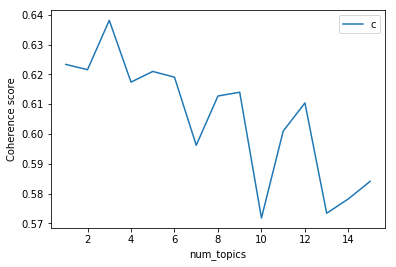

In [25]:
evaluate_graph(c_v_filtered)

In [26]:
# Build topic listings from each model.
def top_topics(lda, num_words=20):
    str_topics = []
    for topic in lda.state.get_lambda():
        topic = topic / topic.sum()  # normalize to probability distribution
        bestn = matutils.argsort(topic, topn=num_words, reverse=True)
        beststr = [lda.id2word[_id] for _id in bestn]
        str_topics.append(beststr)
    return str_topics

def get_super_topic(trained_models):
    model_topics = {}
    super_topic = set()
    for num_topics, model in trained_models.items():
        topics_as_topn_terms = top_topics(model)
        model_topics[num_topics] = topics_as_topn_terms
        super_topic.update(itertools.chain.from_iterable(topics_as_topn_terms))
    print("Number of relevant terms: %d" % len(super_topic))
    return super_topic, model_topics

In [27]:
super_topic, model_topics = get_super_topic(lm_filtered)
print(super_topic)

Number of relevant terms: 2782
{'título', 'análise', 'igaracu', 'receita_líquida', 'exame_cópia', 'panificar', 'multa', 'pgj', 'placa_chassi', 'orlândia', 'sqf_sqf', 'gordura', 'protocolo_cevs', 'emenda', 'gabarito', 'tarde', 'cargo', 'cadáver', 'psaa', 'palácio', 'mandaqui', 'abertura', 'ccb', 'acionista', 'direito_preferência', 'matric', 'teste', 'emissão_documento', 'ituverava', 'fundar', 'auxiliar_enfermagem', 'pretexto', 'acervo', 'alimento', 'tipo', 'série_série', 'inapto', 'cruz_mogi', 'paes', 'prudente', 'cozinha', 'dotar', 'coordenação', 'escrivão', 'cruzar', 'cmn', 'reclamar', 'cirurgia', 'resolução', 'competição', 'descartável', 'vencer', 'cristina', 'alcool', 'proceder', 'cid', 'complemento', 'extrato', 'selho_administrar', 'parte_cao', 'posse', 'praia', 'aceitá', 'trem', 'quota_título', 'solo', 'tema', 'prontuário_perícia', 'sorteio', 'evc_sqc', 'subq', 'constituição', 'mirante', 'coronel', 'itps', 'quinquênios', 'peb', 'recimento', 'cartucho_tinta', 'ata_livro', 'sobremes

In [28]:
%%time
# Now estimate the probabilities for the CoherenceModel

cm = CoherenceModel(
    topics=[super_topic], texts=train_texts,
    dictionary=dictionary_filtered, coherence='c_v')
cm.estimate_probabilities()

2017-08-01 08:36:03,282 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2017-08-01 08:36:58,933 : INFO : 190 batches submitted to accumulate stats from 12160 documents (-491742 virtual)
2017-08-01 08:39:07,064 : INFO : 3 accumulators retrieved from output queue
2017-08-01 08:39:10,488 : INFO : accumulated word occurrence stats for 128195 virtual documents


Wall time: 3min 8s


In [29]:
%%time
cm.get_coherence_per_topic()

[0.80437030549411692]

In [30]:
best_model_filtered.save('mp_model_60topics.lda')

2017-08-01 08:55:35,441 : INFO : saving LdaState object under mp_model_60topics.lda.state, separately None
2017-08-01 08:55:35,505 : INFO : saved mp_model_60topics.lda.state
2017-08-01 08:55:35,521 : INFO : saving LdaModel object under mp_model_60topics.lda, separately ['expElogbeta', 'sstats']
2017-08-01 08:55:35,523 : INFO : storing np array 'expElogbeta' to mp_model_60topics.lda.expElogbeta.npy
2017-08-01 08:55:35,542 : INFO : not storing attribute state
2017-08-01 08:55:35,544 : INFO : not storing attribute dispatcher
2017-08-01 08:55:35,545 : INFO : not storing attribute id2word
2017-08-01 08:55:35,560 : INFO : saved mp_model_60topics.lda


In [31]:
%%time
import numpy as np
# Next we perform the coherence evaluation for each of the models.
# Since we have already precomputed the probabilities, this simply
# involves using the accumulated stats in the `CoherenceModel` to
# perform the evaluations, which should be pretty quick.

coherences = {}
for num_topics, topics in model_topics.items():
    cm.topics = topics

    # We evaluate at various values of N and average them. This is a more robust,
    # according to: http://people.eng.unimelb.edu.au/tbaldwin/pubs/naacl2016.pdf
    coherence_at_n = {}
    for n in (20, 15, 10, 5):
        cm.topn = n
        topic_coherences = cm.get_coherence_per_topic()
        #print('coherence per topic for', n, 'topics', topic_coherences)
        
        # Let's record the coherences for each topic, as well as the aggregated
        # coherence across all of the topics.
        coherence_at_n[n] = (topic_coherences, cm.aggregate_measures(topic_coherences))
        #print('coherence at', n, 'topics', cm.aggregate_measures(topic_coherences))
        
    topic_coherences, avg_coherences = zip(*coherence_at_n.values())
    avg_topic_coherences = np.vstack(topic_coherences).mean(0)
    avg_coherence = np.mean(avg_coherences)
    print("Avg coherence for num_topics=%d: %.5f" % (num_topics, avg_coherence))
    coherences[num_topics] = (avg_topic_coherences, avg_coherence)

Avg coherence for num_topics=9: 0.59222
Avg coherence for num_topics=19: 0.57620
Avg coherence for num_topics=29: 0.59985
Avg coherence for num_topics=39: 0.58408
Avg coherence for num_topics=49: 0.59396
Avg coherence for num_topics=59: 0.59841
Avg coherence for num_topics=69: 0.59034
Avg coherence for num_topics=79: 0.58842
Avg coherence for num_topics=89: 0.57939
Avg coherence for num_topics=99: 0.56359
Avg coherence for num_topics=109: 0.58792
Avg coherence for num_topics=119: 0.59512
Avg coherence for num_topics=129: 0.56000
Avg coherence for num_topics=139: 0.56816
Avg coherence for num_topics=149: 0.56522
Wall time: 7min 10s


In [32]:
# Print the coherence rankings
avg_coherence = [(num_topics, avg_coherence) for num_topics, (_, avg_coherence) in coherences.items()]
ranked = sorted(avg_coherence, key=lambda tup: tup[1], reverse=True)
print("Ranked by average '%s' coherence:\n" % cm.coherence)
for item in ranked:
    print("num_topics=%d:\t%.4f" % item)
print("\nBest: %d" % ranked[0][0])

Ranked by average 'c_v' coherence:

num_topics=29:	0.5998
num_topics=59:	0.5984
num_topics=119:	0.5951
num_topics=49:	0.5940
num_topics=9:	0.5922
num_topics=69:	0.5903
num_topics=79:	0.5884
num_topics=109:	0.5879
num_topics=39:	0.5841
num_topics=89:	0.5794
num_topics=19:	0.5762
num_topics=139:	0.5682
num_topics=149:	0.5652
num_topics=99:	0.5636
num_topics=129:	0.5600

Best: 29


In [33]:
best_model_filtered.print_topics()

2017-08-01 09:03:04,123 : INFO : topic #21 (0.021): 0.060*"ponto" + 0.031*"distância" + 0.030*"linha" + 0.027*"azimute" + 0.024*"coordenada" + 0.024*"faixa" + 0.023*"projeto" + 0.021*"domínio" + 0.021*"limite" + 0.018*"área"
2017-08-01 09:03:04,125 : INFO : topic #2 (0.023): 0.048*"saúde" + 0.046*"pedido" + 0.042*"licença" + 0.040*"tratar" + 0.031*"protocolo" + 0.029*"termo" + 0.026*"efp" + 0.025*"reincidente" + 0.021*"despacho" + 0.020*"atenção"
2017-08-01 09:03:04,127 : INFO : topic #7 (0.023): 0.023*"condutor" + 0.023*"prazo" + 0.023*"ctb" + 0.016*"direito" + 0.016*"suspensão" + 0.016*"veículo" + 0.015*"pena" + 0.015*"port" + 0.014*"cnh" + 0.014*"infração"
2017-08-01 09:03:04,128 : INFO : topic #13 (0.023): 0.059*"pub" + 0.034*"vig" + 0.034*"sábado" + 0.021*"domingo" + 0.016*"pub_pub" + 0.015*"arquivo" + 0.014*"pub_vig" + 0.014*"texto" + 0.014*"sac" + 0.013*"matéria"
2017-08-01 09:03:04,130 : INFO : topic #17 (0.023): 0.069*"campina" + 0.033*"campinas" + 0.023*"campina_campina" + 0.

[(21,
  '0.060*"ponto" + 0.031*"distância" + 0.030*"linha" + 0.027*"azimute" + 0.024*"coordenada" + 0.024*"faixa" + 0.023*"projeto" + 0.021*"domínio" + 0.021*"limite" + 0.018*"área"'),
 (2,
  '0.048*"saúde" + 0.046*"pedido" + 0.042*"licença" + 0.040*"tratar" + 0.031*"protocolo" + 0.029*"termo" + 0.026*"efp" + 0.025*"reincidente" + 0.021*"despacho" + 0.020*"atenção"'),
 (7,
  '0.023*"condutor" + 0.023*"prazo" + 0.023*"ctb" + 0.016*"direito" + 0.016*"suspensão" + 0.016*"veículo" + 0.015*"pena" + 0.015*"port" + 0.014*"cnh" + 0.014*"infração"'),
 (13,
  '0.059*"pub" + 0.034*"vig" + 0.034*"sábado" + 0.021*"domingo" + 0.016*"pub_pub" + 0.015*"arquivo" + 0.014*"pub_vig" + 0.014*"texto" + 0.014*"sac" + 0.013*"matéria"'),
 (17,
  '0.069*"campina" + 0.033*"campinas" + 0.023*"campina_campina" + 0.023*"mogi" + 0.022*"cruz" + 0.016*"vol" + 0.013*"mogi_cruz" + 0.011*"recurso" + 0.009*"campinas_campinas" + 0.008*"universidade"'),
 (5,
  '0.031*"área" + 0.023*"arquivo" + 0.019*"trim" + 0.016*"publicar

In [34]:
pyLDAvis.gensim.prepare(best_model_filtered, corpus_filtered, dictionary_filtered)

2017-08-01 09:03:11,358 : DEBUG : performing inference on a chunk of 41283 documents
2017-08-01 09:04:10,309 : DEBUG : 41283/41283 documents converged within 400 iterations
D:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
25     9.697368        1       1  0.100292  0.088431
23     7.311601        1       2  0.239566 -0.081966
28     6.668697        1       3  0.005214 -0.085072
27     6.538831        1       4  0.018617 -0.124245
11     5.341646        1       5  0.240144 -0.060629
16     5.321190        1       6  0.254530 -0.073288
6      5.190995        1       7 -0.194288 -0.131024
8      4.130233        1       8  0.078492  0.039384
19     3.987389        1       9 -0.143682 -0.139016
3      3.674003        1      10 -0.004392 -0.064434
24     3.292340        1      11  0.079858  0.241571
15     3.282017        1      12 -0.007760 -0.051207
1      3.213490        1      13  0.062761 -0.043798
4      3.037038        1      14  0.031019 -0.000058
14     3.030850        1      15  0.107134  0.102601
0      2.706101        1      16 -0.185365 -0.068353
18     2.424125        1      17  0.021432 -0.045089
22     2.314651        1      18 -0.090123 -0.100692
10     2.220628        1      19  0.034582 -0.036297
9      2.128567        1      20 -0.135042  0.235654
26     1.886543        1      21 -0.077925 -0.072679
20     1.867778        1      22  0.099339  0.005304
2      1.671203        1      23 -0.144232 -0.007644
29     1.607201        1      24 -0.033146 -0.016823
5      1.444854        1      25 -0.014494  0.085985
13     1.372526        1      26 -0.055920  0.173583
7      1.322221        1      27 -0.098159 -0.003783
12     1.298337        1      28 -0.151391  0.074436
21     1.040567        1      29 -0.025183  0.135813
17     0.977010        1      30 -0.011878  0.023337, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
1148   Default  24556.000000             lei  24556.000000  30.0000  30.0000
1928   Default  11080.000000       candidato  11080.000000  29.0000  29.0000
59     Default  16956.000000            item  16956.000000  28.0000  28.0000
62     Default  28316.000000           valor  28316.000000  27.0000  27.0000
7685   Default   3855.000000             efp   3855.000000  26.0000  26.0000
1707   Default  14541.000000         decreto  14541.000000  25.0000  25.0000
1166   Default  20220.000000           termo  20220.000000  24.0000  24.0000
138    Default   9607.000000           preço   9607.000000  23.0000  23.0000
30     Default   7217.000000           ativo   7217.000000  22.0000  22.0000
1241   Default   3878.000000           ponto   3878.000000  21.0000  21.0000
739    Default   5017.000000         assunto   5017.000000  20.0000  20.0000
2056   Default   4175.000000          válido   4175.000000  19.0000  19.0000
1767   Default   6154.000000        portaria   6154.000000  18.0000  18.0000
123    Default   8539.000000       companhia   8539.000000  17.0000  17.0000
1896   Default   5154.000000         licença   5154.000000  16.0000  16.0000
6000   Default   4378.000000            merc   4378.000000  15.0000  15.0000
1827   Default   7365.000000       inscrição   7365.000000  14.0000  14.0000
11471  Default   5632.000000         sergipe   5632.000000  13.0000  13.0000
6455   Default   3786.000000             peb   3786.000000  12.0000  12.0000
18     Default   6205.000000    demonstração   6205.000000  11.0000  11.0000
2875   Default   2877.000000          apenso   2877.000000  10.0000  10.0000
60     Default  10270.000000          objeto  10270.000000   9.0000   9.0000
68     Default  15194.000000         período  15194.000000   8.0000   8.0000
732    Default   5771.000000       município   5771.000000   7.0000   7.0000
1287   Default   3764.000000            icms   3764.000000   6.0000   6.0000
5915   Default   3487.000000          cetesb   3487.000000   5.0000   5.0000
2252   Default   3912.000000           saúde   3912.000000   4.0000   4.0000
40     Default   5984.000000